# Курс по машинному обучению,   ВМК МГУ
## Линейные модели классификации и регрессии

### Важно! О формате сдачи

* **Все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**

__Цель данного задания:__

- Узнать, что такое переобучение и как с ним бороться в линейных моделях;
- Научиться работать с разными типами признаков;
- Понять, чем отличаются разные регуляризаторы;
- Приятно провести осенний вечер, предсказывая дождь.

При выполнении данного задания необходимо последовательно запустить все ячейки ноутбука и ответить на $20$ вопросов. Ответы на вопросы будут проверены в рамках кросс-ревью. Всего за ответы на вопросы можно получить  25  баллов.

**А также..**

Если в ячейке написана фраза "Ваш ответ здесь", то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Ваш код здесь", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Ваш ответ здесь", и ячейка с фразой "Ваш код здесь", то в ответе ожидается и код, и текст)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

**Юнит-тесты**

Здесь импортируются классы, которые необходимо реализовать самостоятельно. Подробное описание того, что необходимо реализовать вы можете найти в pdf задания. Правильность реализации проверяется юнит-тестами. Максимально за юнит-тесты можно получить  20  баллов. Шаблон решения находится во вкладке "Linear models (unit-tests)" в "шаблоне решения".

In [2]:
from Task import MyOneHotEncoder, SimpleCounterEncoder, FoldCounters

### Часть 1. Линейная регрессия

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

Для обучения линейной регрессии, равно как и для обучения остальных простых моделей (линейные модели, решающие деревья, knn и т.д.) отлично подходит библиотека scikit-learn (sklearn): в ней очень понятный и простой интерфейс.

Однако для обучения более сложных моделей вроде бустинга и нейронных сетей всё же нужно пользоваться специализированными библиотеками: XGBoost, LightGBM, CatBoost и пр. для градиентного бустинга над деревьями, PyTorch, Tensorflow и пр. для нейронных сетей. 

Так как мы будем обучать линейную регрессию, нам подойдет реализация из sklearn. В sklearn есть несколько классов, реализующих линейную регрессию. Основные это:

- Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Также есть SVR, ElasticNet  и пр., но не будем сегодня о них

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Рассмотрим, модельные данные для задачи регрессии. Пусть $x$ будет обычным числом из равномерного распределения, а $y = 0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim \mathcal{N}(0, 0.01)$.

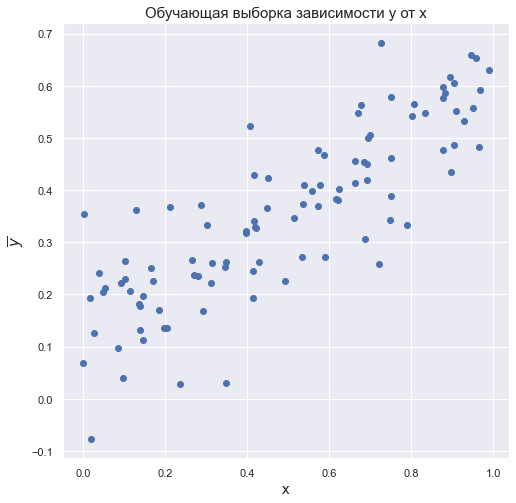

In [3]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

Обучим линейную регрессию, и посмотрим как регуляризация влияет на качество модели. В реализации библиотеки sklearn коэффициент регуляризации задаётся параметром alpha

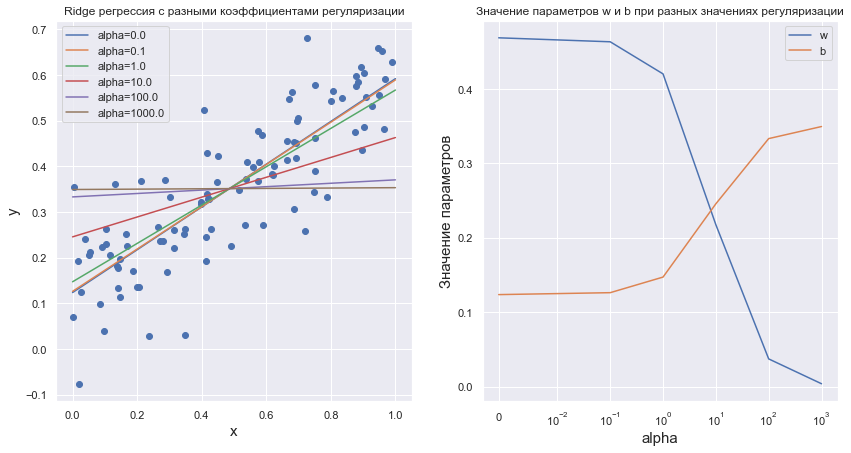

In [4]:
from sklearn.linear_model import Ridge

x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthresh=0.01)
axs[1].legend()
plt.show()

**Вопрос 1** ($1$ балл): Как зависят параметры модели от константы регуляризации? А качество?

С ростом значения константы регуляризации от 0 до 0.1 значение параметра $b$ незначительно увеличивается, а значение $w$ незначительно уменьшается.
Далее от 0.1 до 1 мы можем наблюдать чуть более быстрый рост у параметра $b$ и чуть более быстрое падение у $w$ (как минимум потому, что у нас неравномерная шкала по параметру $alpha$).
От 1 до 100 у нас происходит сильный рост значения параметра $b$ и еще более сильное падения $w$.
Далее от 100 до 1000 скорости угасают, мы наблюдаем примерно то же самое, что и на интервале от 0.1 до 1.
Таким образом, с ростом коэффициента регуляризации значение параметра $b$ увеличивается с резким скачком на (1, 100), а значение параметра $w$ уменьшается на всем интервале наблюдения значений константы регуляризации с резким скачком на том же интервале от 1 до 100, и при значении 1000 уходит совсем в ноль.

Что касается качества работы, то с ростом параметра $alpha$ угол наклона прямой относительно оси $X$ уменьшается. Соответсвенно уменьшается и точность (качество) Ridge регрессии. При этом до $alpha = 1$ качество работы примерно одинаково хорошее. При $alpha = 10$ качество хорошенько ухудшилось. А далее, при больших значениях параметра $alpha$, качество регрессии становится неприемлемо плохим.

**Вопрос 2** ($1$ балл): Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции и увиденные картинки.

Потому что, он лишь выравнимает модель. От него не зависит адекватность работы алгортма.

Казалось бы, зачем нам эта глупая регуляризация?! 

Давайте рассмотрим ещё один модельный пример. Представим, что кто-то добавил в данные к переменной $x$ её же умноженную на $2$. То есть, теперь у нас два признака $x_1$ и $x_2 = 2 \cdot x_1$. Тогда, $y = c \cdot 0.5 \cdot x_1 + \frac{c - 1}{4} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. Это может привести к тому, что без регуляризации мы рискуем выучить очень большие веса!

In [5]:
np.random.seed(1)
X2 = np.hstack((X[:, None], 2 * X[:, None]))
Y2 = X2[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X2, Y2)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 0.1006220738265918 	w2: 0.20124414765318363


Коэффициенты адекватные, хотя и не похожи на изначальную зависимость. Но что, если $x_2$ будет равняться $3 \cdot x_1$?

In [6]:
np.random.seed(1)
X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 20574703741844.47 	w2: -6858234580614.654


Тут вот уже не повезло. Коэффициенты случайно выучились неадекватно большими. Создадим обучающую выборку из того же распределения и посмотрим на качество

In [7]:
np.random.seed(2)
X3_test = np.random.uniform(0, 1, 100)
X3_test = np.hstack((X3_test[:, None], 3 * X3_test[:, None]))
Y3_test = X3_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

Y3_test_pred = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss: %.4f" % np.mean((Y3_test_pred - Y3_test) ** 2))

MSE loss: 0.0202


Вроде бы неплохое, но что если мы добавим ко второму признаку одного из объектов небольшой шум?

In [8]:
X3_test[0, 1] = X3_test[0, 1] + 1e-10
Y3_test_pred_noisy = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss:", np.mean((Y3_test_pred_noisy - Y3_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y3_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y3_test_pred[0])

MSE loss: 4701.590584117163
Предсказание для первого объекта с шумом:  -685.408203125
Предсказание для первого объекта без шума:  0.416015625


Как видим, даже небольшое изменение в данных, приводит к резкому падению качества.

**Вопрос 3** ($1$ балл): Рассмотрите больше примеров с двумя признаками $x_1$ и $x_2$, где $x_2$ линейно зависит от $x_1$. Убедитесь, что линейная модель без регуляризации крайне неустойчива.

In [9]:
print("x2 = 5 * x1")
np.random.seed(1)
X4 = np.hstack((X[:, None], 5 * X[:, None]))
Y4 = X4[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
reg = Ridge(alpha=0.0)
reg.fit(X4, Y4)
print("Веса БЕЗ регуляризации   -\t w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
np.random.seed(2)
X4_test = np.random.uniform(0, 1, 100)
X4_test = np.hstack((X4_test[:, None], 5 * X4_test[:, None]))
Y4_test = X4_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
Y4_test_pred = np.sum(reg.coef_[None] * X4_test + reg.intercept_, axis=1)
print("MSE loss БЕЗ шума: %.4f" % np.mean((Y4_test_pred - Y4_test) ** 2))
X4_test[0, 1] = X4_test[0, 1] + 1e-10
Y4_test_pred_noisy = np.sum(reg.coef_[None] * X4_test + reg.intercept_, axis=1)
print("MSE loss С шумом:", np.mean((Y4_test_pred_noisy - Y4_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y4_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y4_test_pred[0])
np.random.seed(1)
X5 = np.hstack((X[:, None], 5 * X[:, None]))
Y5 = X5[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
reg = Ridge(alpha=0.1)
reg.fit(X5, Y5)
print("Веса С регуляризацией    -\t w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

print("\nx2 = 6 * x1")
np.random.seed(1)
X6 = np.hstack((X[:, None], 6 * X[:, None]))
Y6 = X6[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
reg = Ridge(alpha=0.0)
reg.fit(X6, Y6)
print("Веса БЕЗ регуляризации   -\t w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
np.random.seed(2)
X6_test = np.random.uniform(0, 1, 100)
X6_test = np.hstack((X6_test[:, None], 6 * X6_test[:, None]))
Y6_test = X6_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
Y6_test_pred = np.sum(reg.coef_[None] * X6_test + reg.intercept_, axis=1)
print("MSE loss БЕЗ шума: %.4f" % np.mean((Y6_test_pred - Y6_test) ** 2))
X6_test[0, 1] = X6_test[0, 1] + 1e-10
Y6_test_pred_noisy = np.sum(reg.coef_[None] * X6_test + reg.intercept_, axis=1)
print("MSE loss С шумом:", np.mean((Y6_test_pred_noisy - Y6_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y6_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y6_test_pred[0])
np.random.seed(1)
X7 = np.hstack((X[:, None], 6 * X[:, None]))
Y7 = X7[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1
reg = Ridge(alpha=0.1)
reg.fit(X7, Y7)
print("Веса С регуляризацией    -\t w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

x2 = 5 * x1
Веса БЕЗ регуляризации   -	 w1: 13718376158511.783 	w2: -2743675231702.2554
MSE loss БЕЗ шума: 0.0208
MSE loss С шумом: 751.9975602231005
Предсказание для первого объекта с шумом:  -273.9501953125
Предсказание для первого объекта без шума:  0.41796875
Веса С регуляризацией    -	 w1: 0.019341815722458806 	w2: 0.0967090786123

x2 = 6 * x1
Веса БЕЗ регуляризации   -	 w1: 20574703741844.473 	w2: -3429117290307.328
MSE loss БЕЗ шума: 0.0207
MSE loss С шумом: 1174.8919878392235
Предсказание для первого объекта с шумом:  -342.4921875
Предсказание для первого объекта без шума:  0.41796875
Веса С регуляризацией    -	 w1: 0.013593338731656218 	w2: 0.08156003238983561


Теперь добавим регуляризацию и посмотрим, как меняются значения весов в зависимости от значения коэффициента регуляризации.

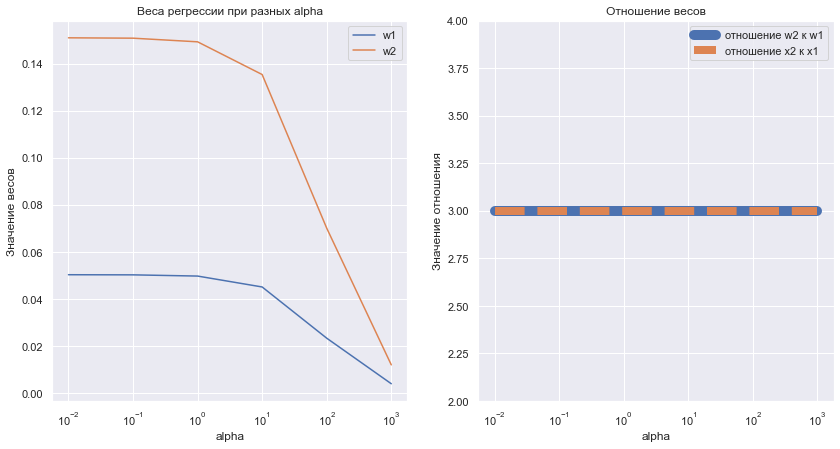

In [10]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])
    
w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

**Вопрос 4** ($2$ балла): Как думаете, почему отношение между весами постоянно?

(подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

Пусть L - функция потерь. Приводим ее к зависимости от w1/w2. Далее, посчитав производную по этому отношению, мы имеем, что она ровна нулю. Это означает, что отношение w1/w2 - постоянная величина. Это и объясняет, почему отношение между весами постоянно.

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

**Вопрос 5** (2 балла): Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов?

(подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля)

Свойство разреживания весов для l1 регуляризации необязательно. При разных значениях константы регуляризации могут как все веса занулится, так и ни один, в общем случае. Пример показывает, что хотя бы один вес зануляется всегда. Если посчитать частные производные и приравнять их к нулю, то мы и имеем, что полученная зависимость весов и приводит к занулению весов, то есть к их разреживанию. 

Добавим  $l_1$  регуляризацию и посмотрим, как меняются значения весов в зависимости от значения коэффициента регуляризации.

In [11]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=1.)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.03950662786303303

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.154883773526191

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.16642148809250684

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.16757525954913835

Веса, при alpha = 0.00001
w1: 0.42615381297565086 	w2: 0.025639365702918023



**Вопрос 6** ($2$ балла): Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?

Далее некоторые ответы пропускаются. Не успел сделать:(

In [12]:
#Ваш код здесь ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуем обучить линейную регрессию на специальном датасете из sklearn

In [13]:
from sklearn.datasets import fetch_california_housing

In [14]:
X, y = fetch_california_housing(return_X_y=True)
X_train, y_train, X_test, y_test = X[:10000], y[:10000], X[10000:], y[10000:]

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
reg = Lasso(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Test MSE = 0.6847


Проанализируем ошибку на обучающей выборке.

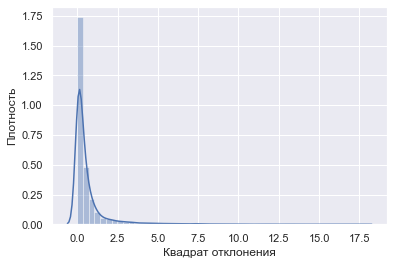

In [17]:
error = (y_train - reg.predict(X_train)) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Как видно, есть несколько объектов, на которых модель ошибается сильно. Давайте удалим их из обучающей выборки.

In [18]:
mask = (error < np.quantile(error, 0.99))
reg.fit(X_train[mask], y_train[mask])
y_pred = reg.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))

Test RMSE = 0.6756


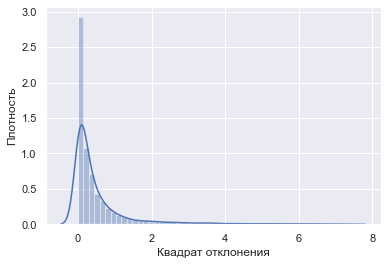

In [19]:
error = (y_train[mask] - reg.predict(X_train[mask])) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Таким образом, можно улучшить качество линейной регрессии, если удалить из обучающей выборки выбросы. В данном примере качество улучшилось не так сильно, но бывают ситуации, когда чистка обучающей выборки по квадратичной ошибке, приводит к сильному улучшению качества.

Также обратим внимание, на веса модели. Часть из них занулилось. Это большое преимущество, так как разреживание весов позволяет отбирать нужные признаки, делая модель более лёгкой.

In [20]:
reg.coef_

array([ 4.02918974e-01,  1.28178142e-02, -0.00000000e+00,  0.00000000e+00,
        4.53555975e-05, -6.81173164e-03, -7.58947693e-02, -0.00000000e+00])

А теперь обучим с  $l_2$  регуляризацией.

In [21]:
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
print(reg.coef_)

[ 4.51549218e-01  5.12533532e-03 -1.19136586e-01  6.66014972e-01
 -5.48001331e-06 -7.24339954e-03 -4.43125173e-01 -3.91587744e-01]


Как видим, веса не разрежены, хотя и есть очень маленькие значения

**Вопрос 7** (2 балла): Приведите пример, когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак?

Ваш ответ здесь ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Часть 2. Классификация

Напомним, что бинарная линейная классификация с классами $0$ и $1$ &mdash; это модель следующего вида:
$a(x)= \begin{cases}
1, & \langle w, x \rangle + b > 0; \\
0, & \text{иначе.}
\end{cases}$
 
где  $w \in \mathbb{R}^d$,  $b \in \mathbb{R}$. В логистической регрессии $p(x) = \frac{1}{1 + e^{-a(x)}}$ интерпретируется как вероятность принадлежности к первому классу. Если объект $x$ принадлежит классу $1$ с вероятностью $p(x)$, то правдоподобие записывается в виде $\prod_{i=1}^{n} p(x_i)^{y_i} \cdot \left( 1 - p(x_i) \right)^{1 - y_i}$. Обучить логистическую регрессию означает найти параметры $w$ и $b$, которые максимизируют указанное правдоподобие. Что эквивалентно минимизации $- \sum_{i=1}^n y_i \log p(x_i) + (1 - y_i) \log (1 - p(x_i))$. Указанная функция потерь называется логистической (или логлосс), и она минимизируется по $w$ и $b$.

По тем же причинам, что и в линейной регрессии, к логистической функции потерь добавляется регуляризация (стандартно это $l_2$).

Рассмотрим пару модельных примеров, в которых целевая переменная $y$ линейно зависит от двух независимых величин $x_1$ и $x_2$, плюс случайный шум.

In [22]:
np.random.seed(1)
X = np.random.randn(100, 2)
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

Обучим логистическую регрессию, двумя методами LBFGS (https://www.ams.org/journals/mcom/1980-35-151/S0025-5718-1980-0572855-7/S0025-5718-1980-0572855-7.pdf) и Newton-CG (https://arxiv.org/abs/1803.02924). Со статьями по ссылкам можно ознакомиться, но это необязательно для выполнения задания (никто вас не осудит, если вы это не сделаете). Для простоты восприятия, можно считать, что первый похож на градиентный спуск, а второй на метод Ньютона.

In [23]:
from sklearn.linear_model import LogisticRegression

clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])
    
coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

In [24]:
x1 = np.linspace(0.5, 3.5, 1000)
x2 = np.linspace(-0.5, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)

def loss(X1, X2, X, Y):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    p = sigmoid(X1[None] * X[:, 0, None, None] + X2[None] * X[:, 1, None, None]) # 100, 200, 200
    return -np.sum(Y[:, None, None] * np.log(p) + (1 - Y[:, None, None]) * np.log(1 - p), axis=0) + 0.5 * (X1**2 + X2**2)

Z = loss(X1, X2, X, Y)

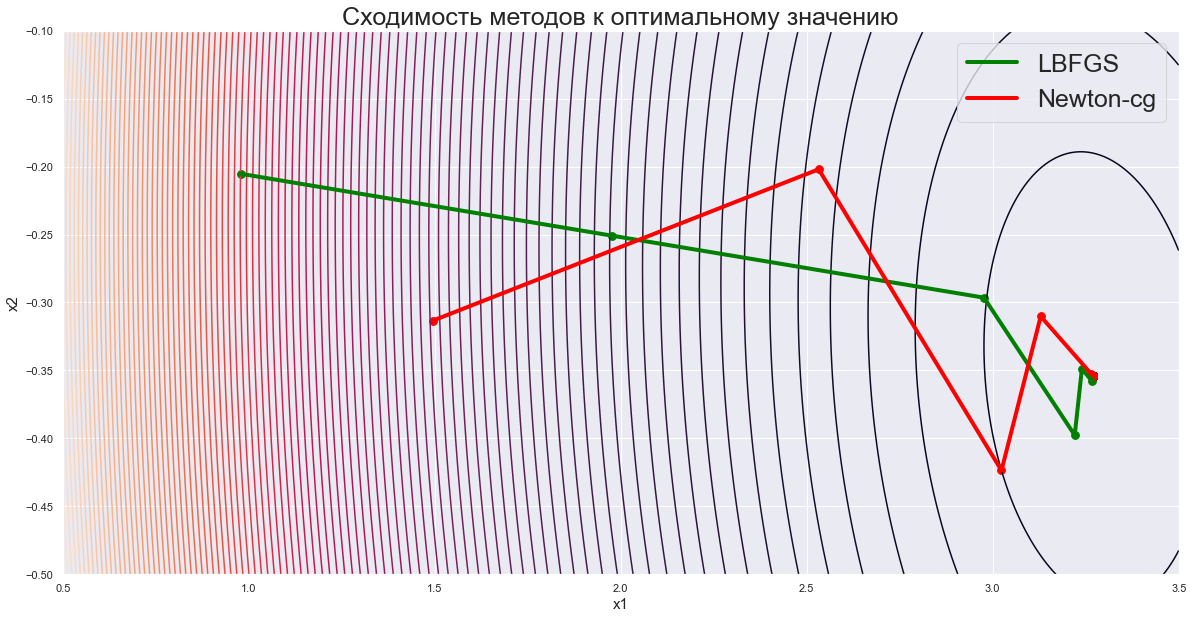

In [25]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

Рассмотрим второй пример. Внимание, здесь $x_2$ уже из другого распределения! 

In [26]:
np.random.seed(1)
X = np.hstack((np.random.randn(100, 1), np.random.uniform(7, 12, (100, 1))))
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

In [27]:
clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])
    
coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

x1 = np.linspace(0, 3.5, 1000)
x2 = np.linspace(0.01, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)
Z = loss(X1, X2, X, Y)

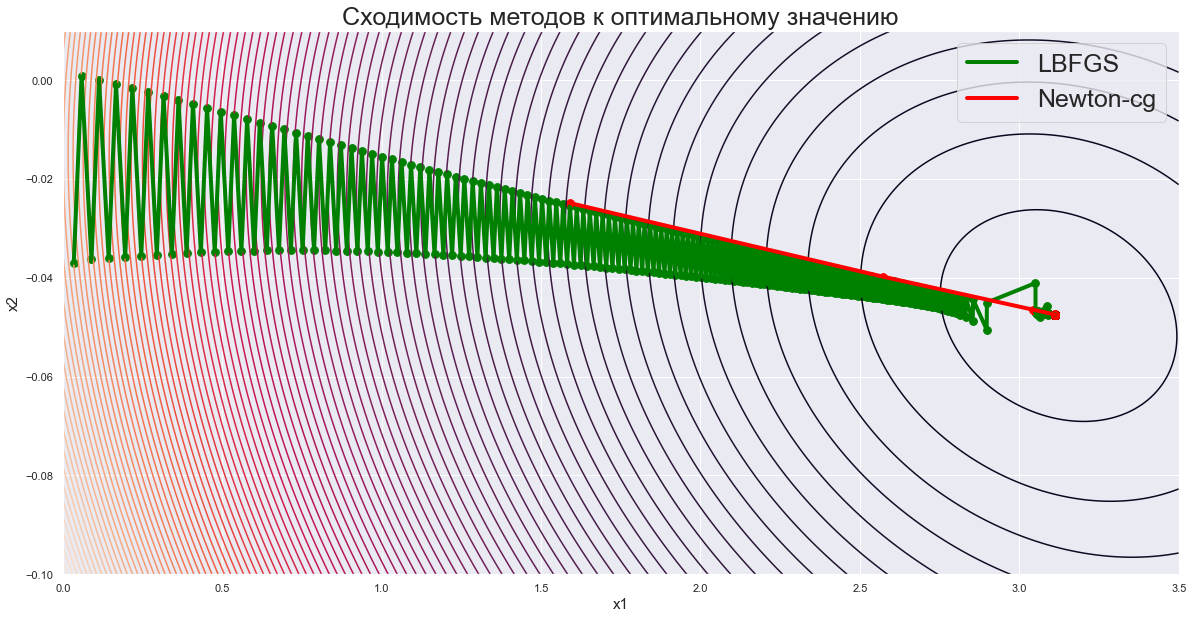

In [28]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

**Вопрос 8** ($1$ балл): Как видим, метод L-BFGS плохо работает на неотмасштабированных данных. Это общее свойство всех методов первого порядка (т.е. использующих только первую производную). Ньютоновские же методы хорошо справляются с подобными ситуациями. В таком случае, почему LBFGS является методом по умолчанию, а не Newton-CG?

В отличие от ньютоновских методов в LBFGS не вычисляется напрямую гессиан функции, т.е. нет необходимости находить частные производные второго порядка. Вместо этого гессиан вычисляется приближенно, исходя из сделанных до этого шагов. Также метод эффективен и устойчив

#### Обучение на реальных данных

Рассмотрим набор данных от метеорологической службы одной страны. В нём требуется предсказать, будет ли дождь на следующий день. Данные лежат в "Linear models (unit-tests)" в "Дополнительные файлы".

In [29]:
df = pd.read_csv("./weatherAUS.csv")
df.tail(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No
145459,2017-06-25,Uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ESE,...,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,No,NaN


**Вопрос 9** ($0.5$ балла): Что это за страна? Подсказка: жители этой страны воспользовались бы методом tail вместо head :)

Эта страна Австралия.

Извлечём немного информации из наших данных

In [30]:
df.shape

(145460, 23)

In [31]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Внимательно приглядимся к столбцам. Напомним, что мы предсказываем значение RainTomorrow. Давайте посмотрим, на этот столбец

In [32]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

Целевая переменная содержит неопределённые значения! Их нужно удалить из всей выборки. Также, переименуем 'Yes' и 'No' в $1$ и $0$.

In [33]:
df = df[df['RainTomorrow'] == df['RainTomorrow']]
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [34]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1., 'No': 0.})
df['RainToday'] = df['RainToday'].map({'Yes': 1., 'No': 0.})

In [35]:
print(df.shape)

(142193, 23)


Объектов стало чуть-чуть поменьше. Давайте выведем немного информации о них

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Как видим, у нас есть 17 признаков имеющих вещественные значения (вещественные признаки), и 5 признаков типа object (категориальные признаки). Для них требуется отдельная предобработка. Пока разобьём выборку на обучающую и тестовую.

In [37]:
from sklearn.model_selection import train_test_split

<img src="https://img.devrant.com/devrant/rant/r_2416968_UUKQJ.jpg" width=360 height=760 />

In [38]:
y = df.RainTomorrow
X = df.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [39]:
X_train.shape

(99535, 22)

#### Вещественные признаки

Как вы могли заметить, среди вещественных и категориальных признаков есть пропущенные значения. В случае с вещественными признаками, пропущенные значения заполняют средним, медианой, нулём или даже пытаются предсказывать по другим признакам. Мы заполним медианой

In [40]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_median = numeric_data.median()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_median)
X_test = X_test.fillna(numeric_data_median)

In [41]:
len(numeric_features)

17

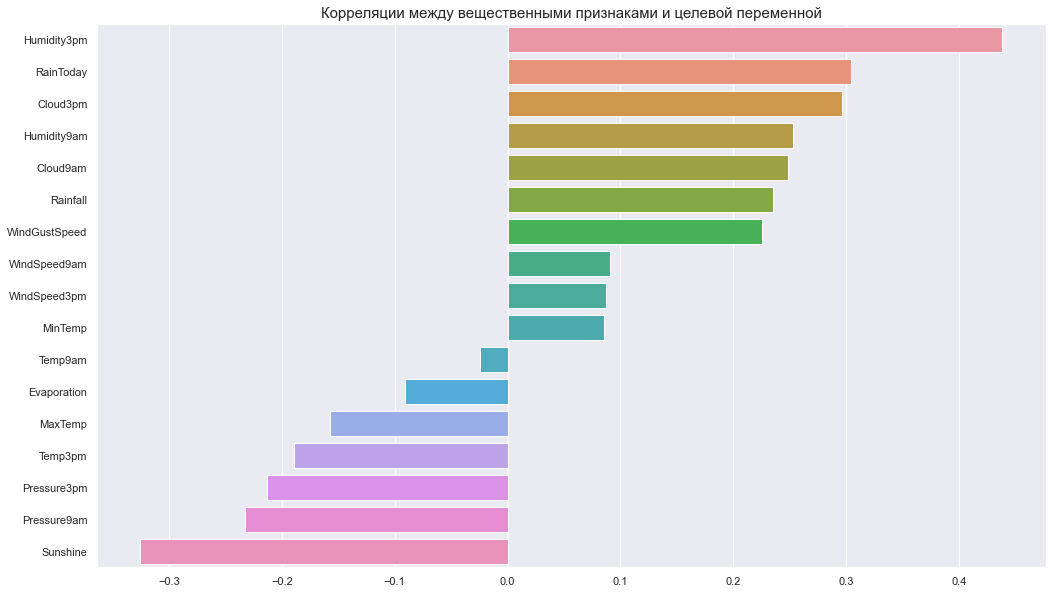

In [42]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.set_title("Корреляции между вещественными признаками и целевой переменной", size=15)
plot.figure.set_size_inches(17, 10)

**Вопрос 10** ($1$ балл): Попробуйте объяснить для каких-нибудь признаков получившиеся значения корреляции (почему для одних эти значения высокие, а для других низкие)?

Как известно, значительная корреляция между двумя случайными величинами всегда является свидетельством существования некоторой статистической связи в данной выборке. Так, например, признак RainToday очень сильно коррелирует с целевым признаком, так как, действительно, в данной есть очевидная статистическая связь между этими признаками.
Отрицательная корреляция — корреляция, при которой увеличение одной переменной связано с уменьшением другой. При этом коэффициент корреляции будет отрицательным. То есть здесь то же самое, но наоборот. Поэтому признак Sunshine имеет очевидную огромную связь с тем, будет ли долждь завтра, но знак минус здесь показывает, грубо говоря, что, чем ярче светит солнце, тем меньше шансов наблюдать дождь на следующий день.
Таки образом, были выбраны 2 признака с большой по мдулю корреляцией с целевым признаком. 

Дополнительно визуализируем признаки Sunshine и Humidity3pm. Библиотека seaborn предоставляет график swarmplot, который в отличие от scatterplot старается разместить на графике как можно больше точек, так чтобы они не пересекались, уложившись при этом в заданную ширину.

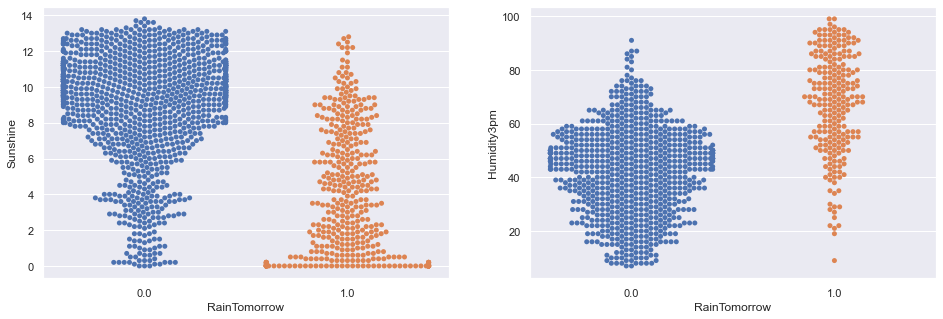

In [43]:
fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
_ = sns.swarmplot(x="RainTomorrow", y="Sunshine", data=df.head(10000), ax=axs[0])
_ = sns.swarmplot(x="RainTomorrow", y="Humidity3pm", data=df.head(1000), ax=axs[1])

Для оценки качества классификации воспользуемся реализованными в sklearn logloss и ROC AUC. ROC AUC является метрикой по умолчанию для бинарной классификации, поскольку очень устойчива к несбалансированности классов. Обучим  логистическую регрессию на вещественных признаках, не подбирая константу регуляризации

In [44]:
from sklearn.metrics import log_loss, roc_auc_score

In [45]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train[numeric_features], y_train)

LogisticRegression(max_iter=1000)

In [46]:
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]
y_train_pred = model.predict_proba(X_train[numeric_features])[:, 0]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, np.where(y_train_pred > 0.5, 0, 1)))

Test logloss = 2.1466
Train logloss = 2.1360
Test roc auc score = 0.7143
Train roc auc score = 0.7109


**Вопрос 11** ($1$ балл): Сколько итераций понадобилось для обучения логистической регрессии?

In [47]:
print("Для обучения логистической регрессии понадобилось {} итераций.".format(model.n_iter_[0]))

Для обучения логистической регрессии понадобилось 575 итераций.


Выведем гистограмму обученных весов

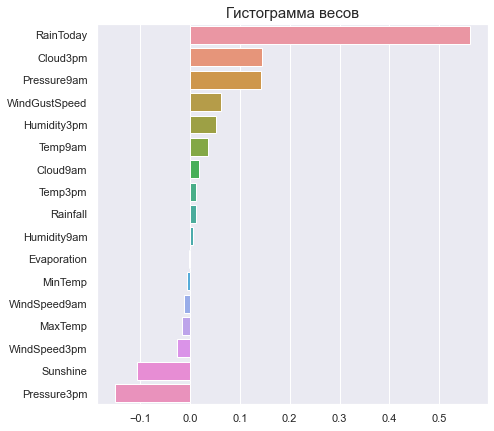

In [48]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

Если приглядеться к весам, то можно увидеть, что между корреляциями признаков с целевой переменной и значениями соответствующих весов мало общего. Чтобы это предотвратить, будем масштабировать наши признаки перед обучением модели. Это, среди прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

In [50]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

**Вопрос 12** ($2$ балла): А сколько итераций потребовалось теперь? Как это связано с модельным примером?

Потребовалось 33 итерации. Это связано с тем, что нормализация признаков уменьшила разброс между признаками. Так как мы имели дело с очень большим разбросом корреляции, то после нормализации мы привели признаки к общему маштабу, что позволяет провести более быстрое и точное вычисление.

In [51]:
y_pred = model.predict_proba(X_test_scaled)[:, 0]
y_train_pred = model.predict_proba(X_train_scaled)[:, 0]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, np.where(y_train_pred > 0.5, 0, 1)))

Test logloss = 2.1801
Train logloss = 2.1699
Test roc auc score = 0.7193
Train roc auc score = 0.7155


In [52]:
print("Для обучения логистической регрессии понадобилось {} итераций.".format(model.n_iter_[0]))

Для обучения логистической регрессии понадобилось 33 итераций.


**Вопрос 13** ($2$ балла): Сравните получившееся качество с качеством до нормализации. Объясните, почему оно изменилось, хотя мы применяли линейную модель к линейно преобразованным признакам? Могло ли качество измениться в другую сторону?

В данном случае, работа алгоритма с нормализации дает существенно лучший результат, особенно в плане эффективности.
Для этого, в общем-то и делается нормализация признаков. Если начальный набор данных имеет большой разброс, то мы заведомо попадаем в яму преобладание определенных признаков. Это и затрудняет процесс обучения. Поэтому, в общем случае, нормализация приводит к улучшению результатов. Но вполне возможна конфигурация признаков, когда нормализация приведет к ухудшению результатов. Например, когда признаки и так были хорошими, а нормализация их лишь слегка поменяла. 

А теперь построим гистограмму получившихся весов

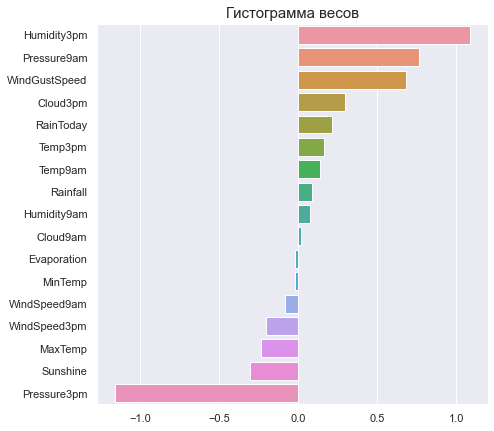

In [53]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

**Вопрос 14** ($1$ балл): Почему даже после нормализации график не до конца похож на гистограмму корреляций?

Потому что нормализация лишь приводит признаки к общему маштабу. Это не означает идеализация признаков, а лишь только сглаживание разрывовов между ними.

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это C — коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем alpha по логарифмической сетке, чтобы узнать оптимальный порядок величины).

**Вопрос 15** ($1$ балл): Чем отличаются валидационная и тестовая выборки?

Тем, что валидационная выборка - выборка данных, которая используется для подбора параметров, выбора признаков и принятия других решений, касающихся обучения алгоритма. А тестовая выборка - выборка, которая используется для оценки качества работы алгоритма, при этом никак не используется для обучения алгоритма или используемым при этом обучении параметрам.

Best C = 38.8816


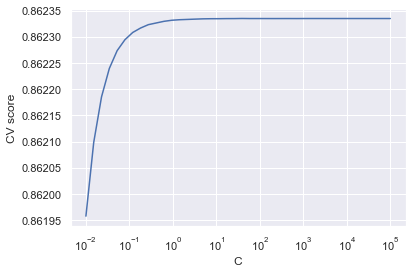

In [54]:
from sklearn.model_selection import GridSearchCV

C = np.logspace(-2, 5, 40)
searcher = GridSearchCV(LogisticRegression(solver='lbfgs'), [{"C": C}], scoring="roc_auc", cv=10)
searcher.fit(X_train_scaled, y_train)

best_C = searcher.best_params_["C"]

print("Best C = %.4f" % best_C)

_ = plt.plot(C, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
plt.show()

**Вопрос 16** ($0.5$ балла): Почему с ростом $C$ качество не падает, хотя модель должна недообучаться?

В документации sklearn С стоит в знаменателе коэффициента регуляризации: alpha = 1/(2C)
И при увеличении С уменьшается коэф. регуляризации => модель переобучается. То есть C из sklearn и коэффициент регуляризации alpha - разные вещи.

**Вопрос 17** ($1$ балл): Почему мы не подбираем коэффициент регуляризации $C$ по обучающей выборке (кросс-валидация не считается, потому что там мы обучающую выборку тоже разбиваем на train и val, но несколько раз)? По тестовой выборке?

Потому что мы хотим увидеть реальные результаты, а не заведомо хорошие результаты на трейне. Есди мы будем выбирать коэффициент регуляризации 𝐶 по обучающей выборке, то это с большой долей вероятности приводило бы к переобучению. А по тестовой, потому что, она не предназначена для этого (смотри вопрос 15). Она предназначена для оценки качества работы алгоритма, а не для подбора параметров.

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся удобным классом Pipeline: обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод fit, а для тестовой — transform), а затем обучить/применить модель (для обучающей fit, а для тестовой — predict)). Pipeline позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую. Однако, если ваши модели не укладываются в использование простых fit, transform и predict, то этот класс вам не подойдёт

In [55]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(solver='lbfgs', C=best_C))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]
print("Test logloss = %f" % log_loss(y_test, y_pred))
print("Test roc auc score = %f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.180343
Test roc auc score = 0.719348


**Вопрос 18** ($1$ балл): Почему качество не выросло?

Выведем результаты без округления для дефолтного С (в прошлой ячейке также поправил вывод результатов - теперь он не огругляется). Из получанного можно сделать незамысловатый вывод, что в данном случае имеется очень слабая зависимость от коэффициента регуляризации С. Поэтому качество работы и не выросло. 

In [56]:
simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(solver='lbfgs'))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict_proba(X_test[numeric_features])[:, 0]
print("Test logloss = %f" % log_loss(y_test, y_pred))
print("Test roc auc score = %f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.180117
Test roc auc score = 0.719258


Рассмотрим теперь категориальные признаки. Сразу отметим, что признак "Date" очень опасен, и лучше пока его выкинуть. Это связано с тем, что мы можем получить прямую о том, будет ли завтра дождь, если текущее место и завтрашняя дата встречались где-то в обучающей выборке. Очень часто также встречаются признак наподобие "ID", которые могут содержать аналогичные утечки информации. С такими признаками всегда нужно обращаться осторожно!

In [57]:
categorical = list(X_train.drop(columns=["Date"]).dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Для работы с категориальными признаками нужно их как-то закодировать числами. Для этого нам понадобится заранее реализованный class MyOneHotEncoder. Вообще OneHotEncoding &mdash; самая стандартная процедура для кодирования категориальных признаков. Помимо библиотеки sklearn, встроенный OneHotEncoder есть в библиотеке pandas и называется get_dummies. Однако сегодня мы не будем пользоваться библиотечными методами:)

Если последующий код выполнятеся слишком медленно, то вероятно Вы реализовали MyOneHotEncoder без использования векторных операций из библиотеки numpy. Попробуйте метод numpy.vectorize

In [58]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', MyOneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('classification', LogisticRegression(solver='lbfgs', max_iter=200))
])

model = pipeline.fit(X_train.drop(columns=["Date"]), y_train)
y_pred = model.predict_proba(X_test.drop(columns=["Date"]))[:, 0]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

Test logloss = 2.2765
Test roc auc score = 0.7292


Качество немного выросло, если смотреть на ROC AUC!

Давайте попробуем счётчики.

Напомним, что счётчики преобразуют категориальный признак в три значения:

1. Доля successes объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.  $$\begin{align}
successes = \frac{\sum_{k=1}^{n_{objects}} y_k \mathbb{I}[x^{i}_k = a_j]}{\sum_{k=1}^{n_{objects}} \mathbb{I}[x^{i}_k = a_j]}
\end{align}$$
2. Доля counts объектов в обучающей выборке с таким же значением признака. $$\begin{align}
counters = \frac{\sum_{k=1}^{n_{objects}} \mathbb{I}[x^{i}_k = a_j]}{n_{objects}}
\end{align}$$
2. Сглаженное отношение двух предыдущих величин: $$\begin{align}
relation = \frac{successes + a}{counters + b},~a \geq 0,~b \geq 0
\end{align}$$

Здесь $\mathbb{I}$ &mdash; индикаторная функция: $\mathbb{I}[\zeta] = 1$, если выражение $\zeta$ истинно, и $\mathbb{I}[\zeta] = 0$, если выражение $\zeta$ ложно.

In [61]:
scal = StandardScaler()

enc_train = FoldCounters()
enc_train.fit(X_train[categorical], y_train)
X_train_counters = enc_train.transform(X_train[categorical])

enc_test = SimpleCounterEncoder()
enc_test.fit(X_train[categorical], y_train)
X_test_counters = enc_test.transform(X_test[categorical])

X_train_preprocessed = scal.fit_transform(np.hstack((X_train[numeric_features].to_numpy(), X_train_counters)))
X_test_preprocessed = scal.transform(np.hstack((X_test[numeric_features].to_numpy(), X_test_counters)))

model = LogisticRegression(solver="lbfgs")
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict_proba(X_test_preprocessed)[:, 0]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, np.where(y_pred > 0.5, 0, 1)))

KeyError: '[10527, 76597, 26007, 64980, 30171, 74403, 14307, 96770, 7247, 41255, 58424, 4008, 64397, 83814, 69665, 542, 48576, 28439, 385, 27291, 8322, 47537, 81844, 18866, 94624, 39108, 54301, 23772, 67776, 58210, 63804, 62211, 8138, 40762, 3023, 10490, 48717, 96785, 28538, 37382, 37390, 91879, 14977, 37419, 84639, 65375, 54250, 44840, 86236, 6023, 48669, 41661, 58520, 97279, 15944, 92022, 90688, 12469, 90258, 8318, 43880, 80872, 44907, 7545, 68371, 12363, 98675, 3760, 71368, 53628, 95555, 75205, 14111, 41635, 70446, 18932, 15039, 63062, 75022, 20278, 86882, 59473, 89821, 64069, 98307, 63128, 8973, 41023, 96332, 80426, 37969, 16754, 49074, 13262, 28783, 49697, 8697, 56312, 83540, 3316, 95917, 5242, 73836, 26572, 95235, 66895, 20850, 77686, 54034, 23260, 75973, 70342, 89869, 45738, 66224, 31585, 33730, 95960, 23818, 14459, 79217, 69941, 26604, 21081, 58367, 1833, 6884, 32576, 93976, 18202, 1746, 4518, 82418, 5319, 97580, 14662, 422, 92876, 84252, 73942, 87888, 14728, 67570, 50475, 35486, 80958, 32711, 7485, 93937, 21032, 68415, 25020, 64008, 91634, 39175, 35304, 13106, 29185, 55776, 57074, 27888, 10421, 25141, 44383, 4537, 24035, 87756, 62077, 35133, 67430, 75342, 75954, 74532, 14317, 77566, 68581, 19985, 75475, 22859, 1570, 92177, 60192, 52447, 9334, 24593, 4612, 37662, 20845, 59853, 11691, 68442, 41727, 90307, 8445, 41772, 41497, 92536, 68348, 44357, 11971, 98125, 76156, 32230, 22323, 55708, 14198, 28882, 44407, 70937, 24143, 39431, 13654, 59701, 42072, 75745, 54698, 30669, 68106, 15704, 6567, 84751, 62992, 59477, 79325, 53704, 79215, 86517, 48501, 97103, 66164, 81012, 77192, 13411, 26206, 95855, 98511, 23532, 69431, 5971, 56422, 60990, 88095, 98033, 51364, 21732, 3915, 44728, 3761, 69533, 94926, 86484, 75598, 52642, 96022, 34056, 43051, 13979, 45406, 10608, 29798, 66708, 66654, 34602, 18947, 26750, 70050, 62393, 75834, 28608, 14999, 55763, 31110, 58047, 79598, 44581, 15574, 73841, 72026, 9750, 66400, 20639, 7241, 89836, 39485, 67903, 37584, 45756, 47886, 46692, 98272, 68909, 6503, 13688, 29505, 69871, 3357, 76142, 15947, 21401, 31994, 97926, 30127, 17631, 18071, 79807, 75030, 58581, 10817, 59428, 98040, 7488, 18547, 12945, 95215, 26343, 77406, 54385, 86326, 7685, 42999, 89198, 25883, 18171, 54033, 9431, 88198, 38393, 41703, 36638, 29884, 26046, 54339, 26940, 31158, 75358, 6574, 21181, 83124, 20381, 28425, 46277, 70363, 59641, 86692, 31181, 34122, 1293, 66572, 85997, 1217, 39648, 30658, 9010, 32590, 88045, 41854, 65708, 81043, 55619, 19141, 73268, 81528, 16078, 43155, 16896, 6822, 41354, 7353, 20317, 24485, 69892, 44461, 67496, 51077, 96033, 30606, 44662, 21412, 68410, 25557, 46409, 14262, 45041, 91803, 28214, 51456, 44614, 4763, 72511, 52302, 91585, 69571, 25424, 2748, 24267, 61765, 12561, 42345, 90356, 69710, 76844, 77799, 16022, 1547, 40378, 58013, 93851, 15841, 13946, 8953, 65655, 59887, 22123, 40969, 50037, 16864, 88011, 27706, 87301, 53353, 16910, 95184, 6743, 28859, 37933, 65857, 10392, 52108, 89312, 22597, 68595, 87110, 17284, 36664, 16736, 70677, 41600, 22062, 21211, 68673, 66450, 35205, 42015, 88605, 15374, 95808, 32098, 62388, 55516, 81988, 64949, 78462, 43386, 1289, 27681, 57472, 12702, 52002, 62746, 97192, 56109, 1197, 81288, 83653, 81375, 88522, 63568, 90050, 69865, 85995, 26539, 32520, 23975, 58245, 71064, 86381, 57618, 67745, 47269, 18631, 17888, 51143, 89956, 5975, 3725, 19757, 35422, 60809, 74201, 21864, 47369, 85213, 42088, 90377, 31848, 17848, 96669, 16699, 30896, 74977, 91277, 8244, 17029, 61500, 2594, 40315, 70771, 88367, 70647, 42348, 70188, 66667, 87991, 66684, 2453, 47662, 62514, 70281, 23995, 2525, 91433, 26221, 50091, 24652, 61156, 26315, 41944, 71857, 20689, 74517, 5450, 40913, 58374, 50766, 62337, 95255, 548, 51445, 93958, 30976, 27281, 39312, 86803, 34890, 69570, 80227, 69890, 69639, 41135, 74127, 81032, 88033, 89400, 84922, 21106, 69593, 22001, 35202, 87687, 97170, 81244, 90572, 28889, 91076, 20045, 78741, 74641, 32453, 26381, 3675, 69264, 55024, 21028, 29017, 30845, 50031, 50720, 54639, 35104, 8283, 44223, 12535, 87486, 71175, 80404, 1866, 36377, 44265, 35291, 56286, 95351, 5943, 97399, 75545, 13894, 71574, 49046, 24014, 14228, 55688, 41917, 58741, 50255, 43684, 13500, 57505, 12117, 3088, 78104, 37338, 6355, 91391, 76596, 57366, 21047, 86256, 50499, 69467, 84391, 51655, 70706, 40234, 82036, 5733, 31859, 37755, 61489, 34159, 89514, 24784, 99106, 65329, 30419, 56046, 75213, 36054, 1850, 82353, 72246, 25014, 76363, 63458, 55784, 97057, 8660, 54111, 66720, 2015, 23293, 68515, 77841, 83050, 1969, 7299, 1683, 74895, 36760, 43569, 97878, 14190, 86632, 57158, 59333, 65185, 32317, 86115, 91553, 85317, 61467, 8927, 22576, 89632, 46145, 95305, 67907, 9081, 38973, 68164, 90681, 46875, 14584, 89950, 31008, 60364, 18903, 59808, 27399, 93961, 81711, 88839, 69527, 87961, 15437, 24146, 86991, 96998, 73682, 97025, 20316, 88811, 74842, 79920, 61272, 26365, 7730, 67697, 49954, 79464, 90554, 31912, 63836, 55821, 849, 88020, 54161, 98153, 35676, 69237, 55273, 28396, 66056, 66975, 65251, 49596, 92720, 20862, 96331, 70605, 88581, 31568, 71282, 98774, 3271, 6450, 18814, 15634, 51603, 41409, 84128, 57128, 70458, 5494, 46018, 54169, 32533, 47350, 56119, 79570, 98438, 2219, 72097, 22798, 2681, 54679, 86255, 73935, 82366, 27036, 43007, 5168, 52879, 39644, 45155, 90950, 76215, 56603, 72477, 12464, 25070, 40075, 84646, 39341, 88603, 69790, 44052, 69288, 34816, 29037, 35157, 62668, 64476, 4978, 69829, 84470, 18626, 6292, 90801, 14856, 90722, 2088, 6366, 66806, 65333, 45952, 77021, 34491, 49497, 6716, 17113, 7119, 96774, 69094, 89221, 91479, 50198, 87652, 28043, 12919, 79027, 77207, 23197, 90761, 88420, 99318, 90485, 89594, 34974, 60919, 66729, 62709, 51837, 57491, 35857, 92200, 47858, 73755, 30501, 76440, 23163, 32301, 74970, 74442, 31619, 54358, 85522, 61358, 25354, 69166, 7341, 14430, 66350, 48218, 36816, 2532, 16807, 87633, 94549, 74430, 93326, 74367, 39241, 40970, 45051, 85985, 27305, 36804, 68251, 10975, 66621, 34473, 35388, 33834, 5657, 35262, 76226, 34661, 53534, 11949, 29592, 73589, 90030, 72087, 33691, 21131, 81232, 81021, 34581, 42902, 82414, 11564, 89816, 61367, 21835, 28464, 84327, 46683, 36797, 78969, 36031, 28892, 81745, 40783, 85836, 96414, 71594, 47488, 8967, 14608, 20463, 25833, 68395, 13365, 62078, 69959, 54840, 23941, 60071, 34623, 38711, 51437, 61214, 18561, 69139, 94765, 56042, 6294, 26364, 88720, 8439, 68591, 88653, 20586, 15400, 58477, 39939, 5385, 45902, 28242, 23834, 93513, 53695, 39686, 58897, 76130, 47549, 66947, 14058, 55163, 37459, 29323, 55609, 86727, 54739, 80873, 30286, 85078, 70915, 89676, 24948, 69736, 19345, 77859, 25649, 73399, 70952, 42763, 36223, 57041, 281, 2909, 44487, 66326, 23067, 18694, 99442, 71043, 65129, 25320, 61554, 12538, 77256, 32688, 44054, 40496, 20578, 94931, 67156, 32205, 30072, 82029, 90756, 26523, 26878, 51845, 33531, 59851, 41374, 27891, 65711, 6104, 29539, 54807, 14611, 71403, 9736, 38406, 13274, 47338, 58964, 32708, 75653, 95910, 89249, 31600, 26987, 20524, 93145, 41689, 29383, 981, 1745, 63731, 8144, 45983, 85738, 69667, 73615, 41764, 625, 69565, 29968, 26972, 8674, 2954, 37400, 1306, 81092, 55327, 36731, 30412, 35338, 8518, 93950, 41500, 17222, 18066, 10395, 70294, 23493, 2045, 88301, 30497, 47207, 67474, 21444, 61028, 41184, 85511, 62846, 91985, 12281, 48993, 83942, 89858, 91995, 66561, 29576, 13877, 17882, 98017, 69386, 65257, 66846, 71971, 82760, 73920, 86438, 89934, 44300, 57376, 7732, 20487, 13982, 69782, 54660, 48045, 67093, 42012, 83605, 79821, 56920, 70117, 57532, 8675, 71407, 32028, 11789, 3199, 48176, 92557, 19462, 24804, 47715, 74361, 88098, 94430, 71147, 22679, 85254, 94783, 23159, 69626, 62927, 22997, 67940, 86153, 92773, 93931, 75532, 68230, 58988, 29023, 62248, 81691, 57836, 31029, 53455, 35700, 99441, 62346, 59137, 43625, 31775, 48444, 26269, 13712, 77143, 21327, 8611, 18596, 23478, 22588, 35579, 88083, 65825, 10015, 2523, 9141, 97168, 2588, 68764, 8754, 794, 13362, 64940, 28295, 5034, 21297, 68532, 53092, 43918, 87502, 50647, 66132, 69777, 75222, 66241, 73541, 79430, 77314, 38137, 26069, 24020, 27315, 43196, 78555, 49406, 25739, 24148, 47695, 1493, 70972, 85408, 56402, 54595, 6211, 60824, 95258, 45955, 84408, 97828, 42796, 39593, 9014, 71845, 18122, 32809, 96384, 42022, 20670, 90658, 13860, 83163, 72880, 26446, 95728, 62138, 78738, 75589, 96868, 13375, 66653, 41825, 3205, 7779, 94705, 64695, 5559, 54691, 61528, 1013, 23891, 30415, 80763, 44756, 93187, 4171, 68740, 83585, 56631, 46684, 68858, 94999, 37978, 77264, 33259, 89425, 13945, 28780, 40961, 7456, 35013, 87810, 66118, 65495, 64535, 29951, 3045, 63854, 91410, 47430, 48110, 70535, 92735, 78279, 52900, 27812, 73467, 71522, 17623, 91114, 27980, 4775, 15933, 40871, 75492, 98580, 56234, 16587, 77896, 48630, 90619, 58617, 71843, 79533, 4494, 8351, 86660, 26079, 41802, 65220, 31699, 32620, 52878, 5811, 41618, 78146, 49567, 5807, 10454, 17279, 10014, 31528, 57952, 51093, 17519, 88721, 28988, 32354, 7035, 73175, 28370, 80555, 71283, 52269, 78371, 9771, 66046, 32989, 57206, 58198, 18709, 43636, 36708, 33686, 97059, 95665, 96041, 88460, 10532, 14131, 96707, 69948, 85299, 56438, 81070, 21602, 53186, 6199, 36121, 18843, 86914, 69835, 89752, 36314, 72229, 44020, 64307, 11086, 20797, 32097, 72607, 89965, 10770, 51225, 35659, 63036, 40253, 77569, 37959, 95399, 18226, 8911, 56704, 45058, 82432, 934, 29276, 70878, 18937, 57743, 23972, 58909, 53875, 53829, 75314, 40412, 77418, 31092, 55530, 61740, 88425, 16054, 45937, 34092, 2215, 23240, 60526, 48564, 35026, 95843, 36892, 47469, 11795, 37457, 55773, 49271, 50552, 66754, 69140, 6029, 88602, 54908, 58916, 93561, 52249, 10521, 39086, 70033, 56798, 4126, 26810, 29591, 25849, 66512, 31265, 92768, 91953, 81815, 96815, 44693, 67111, 3955, 52008, 22053, 42938, 93188, 75671, 22348, 12248, 39334, 27310, 58648, 38335, 73884, 77062, 8621, 14782, 44324, 89844, 88792, 42486, 79411, 89098, 28898, 22316, 82094, 64183, 74502, 54886, 72013, 68722, 78415, 84859, 16698, 47868, 84224, 68714, 74690, 69845, 61200, 57685, 73371, 89413, 20936, 68073, 87975, 28708, 11569, 52638, 5039, 169, 2269, 98216, 69582, 19259, 39987, 32217, 75241, 41955, 88567, 95925, 64149, 52696, 68373, 85085, 43012, 51789, 69942, 81725, 48255, 96082, 50687, 6207, 5823, 1104, 93566, 64408, 27512, 35675, 27478, 61018, 84191, 35669, 79921, 54338, 95928, 98400, 27973, 81003, 54026, 9772, 54456, 16978, 21417, 99057, 64254, 18974, 19647, 23739, 66994, 34063, 51485, 61841, 22515, 87565, 96189, 17582, 65514, 16744, 69926, 22538, 92296, 18196, 81016, 72529, 58456, 55956, 77945, 50124, 45011, 19221, 48747, 26932, 24241, 28604, 70697, 84978, 81421, 35201, 22177, 28374, 72116, 35458, 37880, 36928, 86053, 74651, 16767, 23815, 3557, 52345, 17963, 38707, 23401, 47477, 24231, 27809, 17675, 16700, 91153, 87815, 55912, 59966, 9306, 24270, 74277, 18670, 47406, 40983, 39559, 68272, 75816, 17808, 97381, 42856, 93564, 84988, 41932, 55578, 93717, 51475, 63240, 40478, 82900, 59615, 64163, 9407, 22340, 58539, 58722, 82872, 52376, 93734, 64549, 77231, 3143, 5845, 84584, 40636, 6898, 49474, 90259, 37669, 13381, 27023, 79278, 4078, 12994, 87441, 29725, 8463, 96292, 1274, 76689, 60670, 32891, 80961, 1483, 4564, 54872, 47420, 46316, 68588, 8796, 38808, 66013, 73192, 75540, 42688, 44789, 27480, 96542, 26240, 87041, 11640, 22908, 73273, 72673, 14690, 25821, 24890, 15663, 26578, 48934, 177, 26807, 4960, 64090, 71745, 65348, 26137, 63278, 36040, 79748, 43356, 27978, 89551, 32974, 53848, 4185, 42702, 47297, 54785, 62008, 7815, 86274, 91382, 22531, 70178, 83737, 98100, 85331, 76065, 52981, 55574, 639, 69650, 2285, 55127, 55141, 98587, 96500, 20392, 92219, 57087, 95358, 4715, 7239, 27709, 73423, 9746, 67211, 33420, 33370, 96780, 6910, 82421, 58522, 44163, 79418, 89445, 79587, 19875, 90675, 81251, 14071, 68338, 81224, 55343, 63315, 73306, 18959, 92283, 66976, 21023, 71887, 49084, 5500, 57232, 48807, 52329, 52012, 87572, 11497, 78008, 94551, 30958, 42643, 21447, 12254, 60019, 8245, 19586, 13435, 92330, 66592, 81592, 73433, 85300, 96558, 46285, 80243, 95604, 74954, 34587, 98226, 9121, 70567, 3407, 11136, 27981, 91197, 97792, 87428, 80728, 69939, 15629, 74741, 79987, 99213, 72550, 69018, 24258, 9203, 38452, 49937, 90676, 87536, 54813, 73770, 22290, 12892, 13155, 67617, 42963, 3338, 46696, 90559, 69424, 61518, 67734, 84336, 71419, 20131, 27571, 64153, 84494, 14624, 68630, 399, 94195, 58994, 8194, 5924, 91589, 87696, 57625, 70222, 97462, 13983, 53236, 41187, 21134, 55872, 25838, 27873, 73097, 88983, 8451, 21489, 3104, 94172, 43726, 81859, 80772, 69559, 70761, 5126, 77173, 82804, 28326, 64169, 96017, 17913, 93009, 34255, 51333, 74006, 79326, 66486, 27419, 47563, 50005, 40697, 53205, 29805, 98995, 30339, 81002, 14104, 19189, 8047, 33784, 5349, 80797, 92953, 50456, 54300, 69866, 87858, 91897, 84059, 34726, 80542, 34778, 98048, 79988, 51971, 18605, 92769, 71987, 78032, 76637, 53130, 8539, 2101, 18639, 12688, 80362, 60182, 56051, 37042, 36742, 62105, 74417, 57016, 88067, 73249, 60562, 34804, 10237, 2327, 77166, 42285, 45470, 29840, 74830, 3479, 59703, 79234, 87650, 40586, 73783, 80718, 10444, 75689, 14269, 90621, 17472, 97097, 38260, 56256, 57795, 16083, 88678, 36908, 62054, 44725, 47855, 66789, 49110, 69856, 26142, 45672, 18117, 13747, 10475, 83134, 23586, 94980, 11169, 46829, 196, 34758, 56031, 8811, 75037, 83858, 68222, 51548, 39191, 86550, 99124, 76812, 24249, 5864, 48268, 91593, 4819, 95478, 30840, 66936, 898, 23044, 73072, 51895, 72770, 13487, 65748, 54751, 86909, 25028, 94054, 21634, 78688, 28419, 52441, 85696, 38029, 96257, 37618, 31162, 65036, 68405, 24424, 64508, 76802, 39458, 41430, 44872, 38178, 56243, 77397, 16065, 6857, 38191, 17801, 33698, 65899, 19394, 184, 73899, 19882, 13312, 54655, 58276, 56760, 25940, 16377, 34593, 13592, 13909, 81605, 69961, 75669, 42709, 48546, 69910, 69654, 4425, 8588, 62503, 97294, 73234, 9579, 95187, 81671, 17257, 79316, 18483, 77704, 53838, 5448, 86752, 39869, 25576, 95892, 90523, 57605, 75576, 73977, 99458, 9643, 21669, 50452, 40278, 20749, 13876, 58549, 48764, 17529, 75471, 51304, 39580, 45854, 51631, 98232, 89755, 83219, 67235, 88193, 4358, 33941, 7146, 98353, 67875, 63601, 15773, 4516, 40643, 52409, 21682, 27537, 75569, 7128, 77633, 13973, 70279, 96344, 20480, 74123, 93831, 97295, 37547, 18317, 67456, 15957, 89944, 80495, 73158, 60292, 22947, 58513, 75764, 28284, 29357, 90468, 39437, 81039, 23788, 1453, 12274, 5424, 27083, 87587, 24809, 91258, 60438, 68440, 23158, 79513, 67282, 90548, 52630, 97324, 48666, 25044, 78060, 41603, 70964, 90373, 55326, 17079, 49147, 22525, 56400, 12097, 55051, 13303, 78005, 20652, 24, 28812, 94420, 33470, 81285, 2847, 17056, 58543, 64941, 81495, 83645, 57871, 39972, 55441, 77456, 5859, 54401, 64879, 89849, 60514, 95540, 58249, 8961, 72906, 65490, 64951, 61378, 57720, 48702, 42964, 92460, 14967, 4637, 72422, 3418, 37389, 50668, 98824, 18973, 7907, 91179, 77427, 29030, 11366, 76401, 14083, 45292, 85759, 31506, 78160, 31396, 23999, 58807, 47366, 8627, 71589, 94846, 20124, 93179, 69037, 2106, 80726, 27774, 15613, 91346, 23550, 64105, 9915, 49952, 8177, 60850, 8265, 10630, 54515, 18407, 40886, 74997, 33275, 29477, 73256, 88588, 68808, 70353, 71597, 26341, 75877, 43797, 37475, 29139, 76450, 27299, 98950, 30590, 56490, 23686, 31226, 9981, 34510, 70496, 11637, 69831, 83673, 62583, 1389, 4187, 56612, 41264, 63147, 51771, 51233, 58967, 49536, 34232, 57358, 58011, 53172, 20396, 16580, 31910, 52472, 79367, 59469, 15620, 13578, 94641, 80843, 2742, 85386, 39477, 83676, 75141, 28303, 38423, 3951, 43789, 87233, 75308, 20999, 9916, 64060, 80080, 36933, 2333, 11442, 5654, 34227, 52466, 73496, 66449, 84319, 62225, 20102, 87605, 34838, 48858, 54577, 19246, 63739, 40436, 3046, 90139, 14086, 25851, 63355, 47242, 50636, 34093, 80231, 17281, 21992, 36059, 48244, 78685, 25318, 76648, 22366, 89082, 1824, 49448, 52598, 39632, 28779, 39422, 89350, 53960, 10262, 17000, 73768, 66849, 23560, 19319, 46342, 56248, 8567, 81267, 15541, 29516, 79518, 70038, 23745, 64342, 22264, 28523, 39417, 68309, 78638, 21272, 22002, 10246, 1421, 91844, 9773, 11151, 96836, 99148, 67942, 81060, 84841, 75531, 23985, 83298, 31152, 75996, 37287, 45098, 15255, 53078, 26162, 61197, 69215, 9884, 18354, 57606, 88441, 209, 19962, 76619, 50399, 98543, 70940, 16569, 49475, 6103, 25636, 27598, 52742, 13679, 83625, 11913, 52406, 53218, 20747, 65639, 88748, 49086, 32433, 38152, 91009, 5580, 93005, 33268, 95222, 89245, 22956, 88913, 574, 69634, 40937, 43865, 81958, 41460, 5377, 4939, 67834, 3648, 27646, 24636, 45325, 10441, 99157, 2193, 38582, 68140, 40439, 43580, 35944, 69074, 42164, 58560, 17463, 16158, 67641, 25916, 82284, 16718, 20754, 9163, 60396, 86242, 23114, 70494, 65274, 17236, 79474, 46371, 77495, 66882, 37032, 81614, 10064, 46295, 16737, 81639, 88948, 69306, 62483, 32189, 45940, 91890, 81899, 23513, 4443, 31664, 99275, 73063, 19753, 59229, 33072, 34935, 36645, 43666, 16093, 46412, 68679, 69252, 11696, 69539, 85480, 10349, 19748, 5767, 13277, 76168, 381, 58641, 75282, 4665, 53807, 23355, 42121, 98295, 89050, 48840, 73223, 2242, 1930, 15037, 21856, 69884, 12501, 44106, 43031, 24662, 58601, 86941, 32775, 81803, 42776, 9122, 45562, 36384, 47797, 18128, 29677, 25183, 24931, 2521, 87061, 45572, 38859, 8133, 92704, 32416, 14415, 791, 44453, 98850, 91889, 67151, 11734, 95565, 72066, 36986, 69493, 57693, 69450, 65387, 62518, 27587, 68984, 82831, 94268, 15696, 58796, 50984, 34516, 2801, 26385, 85731, 83572, 15499, 41760, 68707, 51746, 36856, 90924, 53682, 13957, 60238, 17231, 94304, 42815, 65977, 50358, 33968, 80052, 89015, 62692, 40020, 35841, 44095, 26230, 24242, 69692, 71481, 49250, 51057, 20690, 78720, 76086, 36083, 72389, 89992, 3377, 32794, 42153, 56000, 20094, 58876, 16002, 14897, 59389, 51753, 32125, 15121, 52531, 59508, 72702, 37580, 14521, 41004, 92584, 26012, 77443, 4519, 59586, 24611, 53090, 81460, 54246, 51638, 47291, 14764, 68399, 27476, 85364, 6384, 66101, 61084, 68318, 13203, 71035, 87097, 32525, 23659, 53735, 36107, 10849, 4844, 27949, 75687, 1298, 15310, 28760, 12304, 7432, 15973, 89953, 71727, 41788, 40482, 86510, 15137, 370, 84320, 73620, 77776, 11552, 68460, 72085, 29803, 63938, 29102, 62605, 66223, 57183, 23545, 37832, 65466, 13377, 26138, 78183, 15341, 64652, 18739, 16404, 16469, 62581, 52515, 97459, 40574, 91396, 58635, 34343, 57682, 5459, 88154, 60988, 68444, 27124, 89613, 36177, 16148, 83551, 14479, 96661, 97836, 11504, 46930, 92593, 22652, 8129, 94399, 26325, 88784, 78559, 81014, 58113, 26184, 13861, 48987, 19623, 37768, 66874, 12392, 32351, 51901, 69801, 81287, 36878, 69849, 30457, 68658, 62380, 96900, 37603, 20471, 73049, 79754, 83714, 84455, 96833, 25691, 27303, 61758, 8334, 2863, 60936, 42248, 54947, 6972, 84062, 47035, 26090, 45267, 67005, 22271, 39308, 93881, 41745, 55133, 31002, 50526, 39549, 6701, 18503, 40822, 54976, 38589, 61024, 60149, 54005, 6151, 90496, 64263, 89090, 97947, 8406, 37941, 57841, 38784, 5320, 28411, 97416, 31894, 72685, 44963, 4738, 68594, 7073, 46716, 14263, 55790, 90132, 40383, 49033, 68537, 21163, 51959, 22449, 53583, 65662, 74133, 93348, 97246, 56952, 86009, 17508, 16590, 14299, 32288, 21962, 81269, 57840, 58507, 25472, 31170, 46136, 6804, 24326, 84618, 7518, 51937, 69146, 80975, 41633, 54753, 12436, 39603, 80628, 49288, 76036, 64590, 43131, 89385, 82603, 21891, 61066, 81219, 83066, 13108, 82486, 81201, 10565, 6287, 88982, 28289, 73483, 97070, 97734, 5230, 48844, 56013, 41619, 62513, 28143, 22713, 89988, 69652, 83393, 19656, 32715, 64000, 98964, 53834, 73506, 5228, 65385, 3545, 83844, 44605, 84709, 63987, 58908, 46743, 94072, 69072, 74791, 92924, 33405, 97053, 90708, 22942, 60563, 84158, 17945, 24883, 30454, 6282, 24911, 30372, 8064, 82054, 83515, 97336, 73531, 98093, 66503, 22726, 8409, 97573, 12105, 9607, 5996, 59738, 51450, 5592, 58893, 15856, 87068, 28515, 4383, 90285, 82768, 29262, 59230, 9549, 34752, 91164, 40712, 22019, 81555, 27123, 96806, 23616, 78180, 54565, 65915, 88627, 73730, 42010, 86658, 51659, 81023, 90583, 66273, 60860, 63724, 98877, 10617, 51199, 76209, 8286, 54057, 62376, 66528, 62776, 88856, 21014, 20836, 14445, 27101, 47627, 45349, 36011, 83909, 43436, 16247, 30236, 40715, 28679, 70588, 80060, 97038, 71577, 30621, 15364, 72400, 17616, 29137, 25094, 53588, 71029, 25182, 45563, 56270, 62545, 35318, 53304, 35242, 86272, 16258, 34314, 87690, 95410, 98409, 7260, 15799, 72128, 28826, 33326, 94443, 7568, 15129, 18723, 14587, 61392, 29883, 89025, 44562, 68917, 56359, 51812, 76969, 56643, 59468, 68457, 92496, 24484, 41490, 40310, 24071, 38684, 14030, 6686, 46274, 2917, 73338, 79510, 62207, 37381, 69686, 93318, 95629, 61231, 66175, 6983, 41808, 16812, 38468, 71521, 86787, 94825, 3677, 79565, 10917, 50969, 43224, 12730, 69673, 19190, 94787, 23808, 88932, 64367, 56950, 75586, 45968, 44895, 9248, 55561, 41039, 30479, 14959, 51905, 45829, 90231, 75712, 86429, 2835, 14364, 64722, 70674, 1851, 8446, 96602, 70565, 87853, 95092, 26004, 5240, 23075, 41170, 91247, 46708, 46217, 22907, 91049, 94037, 23601, 76449, 86884, 22795, 40767, 62166, 64377, 61813, 89180, 68642, 75042, 4935, 84256, 85764, 28470, 2027, 95143, 89093, 46854, 54603, 66265, 21030, 20263, 78646, 37386, 72700, 48917, 86796, 73358, 31596, 20563, 89226, 17959, 7613, 36706, 4591, 67858, 7306, 18619, 74158, 70315, 8337, 58206, 35444, 72491, 22014, 38166, 35933, 23315, 81059, 25297, 82591, 16524, 57396, 41444, 9805, 92727, 84779, 2483, 17195, 6055, 88310, 14809, 3301, 51490, 16379, 68534, 2243, 82452, 98647, 69566, 31336, 26487, 47503, 17757, 62607, 87122, 48831, 26669, 2918, 20946, 36257, 12953, 37291, 81324, 83974, 84317, 73264, 69165, 80474, 81876, 49523, 96203, 33225, 89776, 40663, 35204, 97308, 94127, 42679, 98532, 98149, 23600, 64896, 48677, 27690, 79212, 69625, 40400, 39287, 98838, 92367, 23656, 91123, 53772, 62213, 37972, 89338, 58794, 49156, 27359, 26730, 95989, 51138, 97692, 41553, 37270, 62981, 41220, 72164, 49004, 83493, 65965, 72018, 20339, 76592, 70823, 25269, 58958, 31918, 71246, 50194, 8651, 70287, 66359, 89633, 4873, 90314, 5453, 89332, 88736, 2539, 78309, 14561, 78909, 99009, 67498, 94807, 54120, 79822, 50033, 91909, 3922, 4345, 1993, 84925, 88661, 95174, 54287, 54222, 28233, 53698, 90080, 72393, 21861, 28618, 54700, 77977, 4216, 94627, 69924, 8389, 9208, 32198, 48543, 57969, 68486, 888, 55077, 75644, 93028, 62050, 79738, 107, 2284, 18638, 28318, 58879, 99287, 28977, 21416, 34967, 75375, 68496, 20615, 62090, 80232, 2001, 78388, 30993, 24601, 30091, 3328, 69993, 44047, 97031, 90846, 82408, 23623, 29298, 66160, 55419, 31972, 46570, 1458, 95472, 4921, 80481, 92354, 93126, 59386, 52246, 28054, 39847, 85710, 21091, 22084, 54712, 82569, 99145, 42423, 40902, 73188, 67771, 15888, 54100, 13072, 44865, 48156, 67869, 88363, 84702, 54468, 51953, 26690, 52134, 67831, 9290, 1304, 29308, 89704, 21076, 70160, 60781, 34931, 49015, 51406, 52992, 57294, 18146, 67702, 30643, 84680, 47530, 53293, 49066, 4940, 68976, 86837, 97621, 69859, 50865, 36391, 83463, 72009, 43924, 10626, 82373, 87979, 71150, 19849, 28227, 88306, 35499, 73949, 95054, 60065, 57965, 31276, 64589, 80649, 54321, 55624, 30244, 97109, 2901, 91614, 9404, 98155, 20987, 70625, 85803, 48715, 28641, 6829, 32360, 8998, 49195, 38367, 26372, 1789, 76337, 72443, 27668, 74802, 90341, 39996, 27615, 85712, 29152, 97507, 29301, 7847, 92379, 41993, 44844, 90514, 82163, 17085, 68563, 17114, 73085, 42366, 6650, 88296, 52837, 93616, 34569, 8677, 28995, 51476, 72472, 38539, 42232, 25993, 52988, 3668, 68370, 39980, 68672, 29696, 57843, 85151, 52089, 53082, 86441, 6989, 63951, 1181, 31763, 64559, 64796, 34197, 28306, 47755, 2429, 69459, 85504, 63042, 64965, 87900, 5567, 32943, 75429, 60902, 91807, 13254, 29253, 64137, 13410, 47302, 78669, 8372, 95112, 6031, 11832, 71474, 30712, 69940, 75924, 69935, 27688, 16013, 31277, 95309, 10158, 41480, 61436, 23641, 75298, 94239, 43483, 36188, 36357, 80762, 79154, 19037, 46577, 5387, 36192, 35036, 93080, 19057, 30253, 79714, 13549, 88399, 54981, 49212, 45301, 12858, 540, 85527, 23120, 93763, 76599, 86956, 22866, 89378, 88422, 34580, 69233, 36859, 7643, 4065, 83633, 33052, 56564, 78826, 64865, 18131, 68686, 53520, 28427, 91487, 21727, 26599, 53749, 10238, 6280, 61140, 47401, 65893, 64801, 87194, 218, 41508, 82674, 13374, 63900, 72470, 58015, 94244, 99495, 44173, 69854, 62365, 77531, 91654, 11603, 97189, 71018, 44330, 53496, 63615, 17721, 11344, 10821, 90848, 54409, 97762, 72772, 74286, 9752, 59871, 5285, 9824, 34741, 77638, 84220, 31615, 96007, 68093, 4434, 72100, 75183, 63753, 51446, 80064, 2142, 6544, 42213, 52020, 32596, 19481, 76355, 36681, 64646, 53621, 87555, 11080, 70436, 14606, 68567, 81024, 25735, 69985, 5489, 83142, 18091, 27077, 14041, 28057, 40390, 69830, 69512, 55364, 63107, 51075, 25389, 42080, 20553, 87112, 58096, 80161, 2495, 91219, 24090, 15043, 21662, 43837, 73550, 49745, 85936, 25240, 77598, 12393, 1401, 23859, 35686, 84461, 15429, 24798, 55399, 59008, 37651, 99132, 45298, 19719, 69332, 43188, 90815, 62973, 95732, 10203, 55862, 5713, 12175, 74609, 42926, 72766, 3535, 10875, 31406, 72471, 94438, 62485, 24637, 63499, 13804, 79047, 59143, 14604, 87163, 22161, 97501, 3816, 21759, 55042, 17282, 92382, 19698, 57517, 33818, 43645, 57672, 51844, 65026, 2653, 7153, 50459, 35683, 10744, 6732, 68240, 93051, 97929, 15340, 91198, 69015, 14591, 11879, 44179, 20446, 34768, 29429, 73491, 8530, 33354, 71777, 82549, 1133, 5056, 52680, 37054, 31888, 56983, 69507, 47962, 46479, 26693, 77544, 53319, 10848, 29745, 72814, 52520, 29265, 91529, 54379, 92298, 85900, 67487, 20249, 79364, 98296, 12640, 4802, 4860, 68321, 92509, 24568, 42211, 16931, 46404, 76283, 60397, 75884, 16616, 68900, 92155, 38209, 28973, 69816, 55145, 47644, 71129, 17167, 89365, 73759, 66829, 69600, 57387, 44107, 18962, 90536, 75961, 32633, 39064, 87754, 72027, 93588, 47273, 2426, 40600, 3347, 9589, 44682, 25726, 65426, 73357, 62391, 43641, 12383, 49690, 97016, 99133, 50899, 74946, 97852, 38725, 27661, 44718, 99128, 257, 32179, 76471, 46584, 16505, 47307, 60481, 9926, 9053, 79614, 47736, 15767, 30944, 1090, 59925, 418, 50093, 4422, 88322, 18589, 83340, 60534, 3803, 82701, 10069, 37957, 24274, 1141, 29672, 74221, 56297, 18484, 80959, 15375, 38811, 74637, 48925, 88903, 20226, 19701, 81878, 31817, 67902, 74908, 75975, 46961, 1288, 11032, 11030, 90126, 92513, 2413, 69832, 51528, 69743, 10926, 47153, 3854, 52060, 24564, 41396, 14366, 57905, 33921, 75624, 83447, 61576, 37128, 52870, 56665, 23966, 7737, 77076, 7741, 82824, 44876, 92357, 69904, 41304, 47117, 22043, 10924, 15982, 73627, 31111, 3796, 5866, 13889, 74848, 44880, 21075, 58480, 33680, 16962, 5714, 62241, 26156, 61217, 85877, 33452, 44732, 89307, 97648, 71773, 79081, 69885, 57492, 37778, 63263, 62502, 9732, 60789, 26208, 3182, 71981, 31346, 49011, 5968, 16263, 58831, 10738, 52201, 18551, 20583, 15485, 50987, 12900, 14316, 2844, 67343, 62655, 42634, 20097, 17358, 42774, 81406, 41073, 27355, 61678, 83024, 50224, 72435, 53951, 59909, 89703, 45415, 19530, 4683, 16421, 29380, 66316, 89789, 55545, 53191, 82199, 38473, 45709, 51495, 73719, 14568, 46138, 5457, 1415, 49628, 77473, 43857, 95423, 92890, 83190, 89989, 41509, 28353, 69702, 34972, 82166, 46400, 62999, 48413, 76190, 48155, 81848, 56636, 3254, 48411, 96937, 72959, 42342, 80936, 25259, 62272, 21090, 78770, 91322, 5655, 48361, 46249, 90564, 26891, 53585, 18738, 96250, 46211, 53395, 32348, 6514, 25497, 76454, 10651, 22715, 11175, 42416, 57258, 99262, 53257, 31190, 56349, 41366, 53365, 33639, 51772, 740, 80672, 97617, 39141, 37595, 28757, 4232, 61695, 50767, 18087, 6737, 70104, 2752, 43703, 24896, 54153, 46084, 4489, 46638, 18823, 27803, 68997, 86826, 35383, 36076, 87800, 2216, 41080, 70569, 38256, 38504, 17630, 82234, 52678, 78132, 64088, 52704, 67020, 60906, 76081, 86682, 62328, 57715, 88467, 5857, 3444, 60172, 48396, 7526, 41487, 49310, 51766, 86064, 41877, 61976, 32666, 93691, 83364, 94836, 15850, 73913, 41044, 21290, 78282, 67976, 75579, 69599, 62941, 82410, 10090, 60698, 13965, 13170, 89161, 51298, 60399, 68694, 31108, 33978, 44310, 9751, 70990, 28356, 73142, 25439, 47261, 9017, 35560, 72548, 74656, 54184, 58996, 10535, 56319, 13985, 22785, 30455, 14616, 41317, 23367, 25962, 8820, 27747, 95886, 29339, 39392, 45263, 86718, 93720, 17399, 37910, 52296, 5233, 97952, 52681, 24283, 94085, 57457, 26597, 74841, 20296, 42843, 89405, 17481, 68254, 99462, 8854, 45311, 49914, 90623, 69864, 10922, 89837, 10884, 14194, 91577, 27805, 91903, 29737, 74489, 68998, 9781, 77913, 80191, 29041, 55764, 55512, 70833, 43486, 83635, 57204, 59140, 37706, 59957, 58057, 52688, 69776, 8618, 37557, 50992, 10719, 4950, 50937, 50578, 87003, 82255, 95489, 51059, 67664, 95962, 81559, 32678, 94712, 2315, 97075, 25391, 9317, 94055, 79393, 69841, 98978, 90881, 51870, 9586, 67404, 82394, 37070, 24158, 98588, 33560, 96279, 61368, 11119, 8259, 53557, 86411, 62279, 83772, 61782, 9951, 83065, 99395, 98333, 17162, 49668, 45605, 87381, 65209, 47907, 39885, 54638, 60400, 99343, 35167, 4153, 27112, 21282, 80212, 42404, 28147, 10519, 30843, 92063, 49882, 49161, 76930, 31960, 26530, 57114, 47130, 47092, 69519, 46293, 81008, 59035, 59363, 67608, 34023, 22598, 53321, 36255, 92714, 15586, 97833, 16020, 79705, 42097, 76510, 41017, 21053, 38282, 53762, 28354, 62868, 31088, 24557, 61772, 51791, 77976, 15762, 7156, 7748, 6143, 22889, 70435, 28993, 26172, 67208, 47994, 55971, 59562, 75122, 77787, 58691, 74350, 70484, 58881, 34059, 89499, 37900, 92189, 14332, 37079, 70947, 32199, 3294, 73150, 81566, 39121, 67741, 47171, 53289, 48028, 69724, 44985, 70278, 17464, 41514, 27430, 3711, 85715, 44533, 40362, 66141, 95194, 92556, 8011, 75752, 44734, 84503, 70793, 78768, 68623, 93394, 72433, 81153, 49841, 56401, 45482, 7798, 973, 57325, 36782, 69327, 69216, 87415, 6232, 28857, 71703, 98606, 99373, 64170, 71836, 31488, 59154, 69897, 59503, 18395, 46157, 82556, 26581, 59631, 83216, 73152, 36010, 69320, 78980, 40560, 84011, 78038, 8829, 29843, 10534, 24710, 85003, 3775, 73445, 34794, 97342, 70380, 84266, 20546, 78617, 3259, 46824, 44159, 73397, 63364, 29959, 62289, 90454, 27156, 89861, 47102, 5504, 40067, 63093, 4964, 99433, 15517, 68489, 40537, 40135, 68889, 38317, 17790, 88992, 92179, 37418, 83098, 10483, 61701, 41816, 14241, 41285, 90339, 49616, 64823, 85861, 92323, 7537, 66130, 14140, 91885, 2781, 92514, 36572, 40968, 41193, 30623, 38964, 75618, 28460, 89684, 81773, 193, 51695, 92577, 3098, 62554, 42997, 87734, 37152, 13852, 98952, 33874, 23005, 33932, 20585, 66762, 88084, 67936, 10254, 85849, 42548, 84640, 47415, 82249, 52137, 80313, 70652, 19114, 85359, 99096, 41437, 91087, 70414, 7221, 74304, 69827, 59278, 98734, 25426, 43718, 46862, 52967, 718, 78998, 60230, 15512, 74296, 8906, 65372, 86309, 13572, 26993, 97535, 63114, 92756, 5982, 59788, 62695, 85972, 94710, 84030, 49706, 46553, 2587, 23173, 67202, 78577, 61674, 18762, 1264, 11167, 34861, 36297, 66530, 6210, 49008, 81071, 21578, 96369, 17332, 82719, 25784, 16050, 31240, 97897, 3100, 90435, 99512, 95480, 52233, 92620, 91754, 29368, 50336, 94803, 28777, 9316, 94922, 49720, 68406, 35909, 20, 96938, 41060, 66453, 49680, 14265, 61415, 97069, 21624, 98256, 41025, 92315, 69643, 76048, 43430, 77276, 69520, 96013, 61897, 82773, 75850, 62685, 48997, 14040, 43753, 30348, 78744, 3308, 79883, 45780, 56547, 40950, 5255, 56512, 15963, 71493, 51440, 52075, 65015, 97564, 96401, 15705, 11170, 5617, 71932, 98551, 78953, 5612, 72249, 68036, 29618, 50508, 8429, 46508, 79868, 73006, 95950, 15925, 47774, 45340, 93274, 89839, 99125, 46352, 11800, 23153, 61588, 17792, 9543, 56871, 93611, 54805, 83030, 81802, 56682, 29652, 3269, 31031, 7878, 48532, 26496, 43593, 38857, 93817, 9329, 85569, 59529, 9283, 52056, 38032, 49375, 33034, 41644, 38761, 45458, 76719, 23671, 84670, 10657, 67755, 59145, 83966, 70801, 63542, 1834, 54073, 67338, 59309, 19513, 6705, 90685, 70557, 30737, 8553, 53993, 37531, 14941, 85911, 18913, 50649, 56907, 21911, 81229, 52271, 47747, 32432, 34746, 60449, 28475, 46152, 45142, 38884, 85776, 18496, 23960, 53433, 65547, 42308, 6755, 90890, 25444, 53952, 79202, 44459, 82575, 41732, 9516, 38475, 16414, 60695, 2675, 81113, 40720, 35997, 22099, 44100, 72024, 98878, 29420, 58495, 7626, 51777, 77444, 98956, 51019, 24661, 67298, 58713, 36667, 81517, 73922, 79786, 66777, 83569, 1818, 37425, 18414, 43040, 28154, 40370, 44863, 13236, 32863, 52363, 6381, 15042, 56479, 84330, 53858, 3708, 7274, 13998, 74740, 18710, 96385, 61635, 73655, 91422, 65239, 66998, 86473, 14554, 76513, 56566, 49038, 82774, 69810, 82292, 3080, 48242, 90920, 79199, 17350, 41647, 21926, 73435, 42996, 57512, 24800, 5999, 93115, 30929, 57224, 54974, 19155, 49543, 31206, 3491, 39798, 61606, 65190, 43317, 22984, 98528, 72960, 79175, 72374, 12119, 98, 41886, 77420, 29206, 74625, 75719, 54189, 56424, 22816, 27402, 17105, 12125, 85166, 94312, 25049, 59533, 58232, 69886, 80747, 3177, 30385, 23590, 92883, 13928, 97300, 60005, 12333, 87385, 89392, 38394, 54538, 97423, 91682, 57650, 83348, 80678, 85771, 30505, 42444, 8352, 63473, 12594, 3355, 53153, 73547, 86772, 72725, 38971, 34801, 97004, 33631, 60385, 65767, 39787, 69900, 27791, 14232, 19966, 1263, 69229, 74170, 90769, 54574, 82943, 9352, 87153, 55801, 43752, 67012, 89478, 37404, 48789, 55156, 11576, 63187, 96293, 86558, 92977, 13649, 3196, 68719, 72916, 69675, 45229, 93141, 58536, 89418, 5108, 55048, 37767, 25327, 84960, 24857, 39653, 97889, 14107, 46691, 86701, 69544, 47185, 93439, 34678, 70198, 74723, 74747, 74, 64151, 5904, 11511, 50462, 49135, 29369, 14373, 30715, 90573, 3526, 5002, 5156, 23041, 40798, 82503, 11727, 58981, 98399, 79627, 53256, 14345, 5948, 25023, 40290, 62646, 55457, 29858, 64270, 24092, 45344, 64428, 10208, 64788, 58237, 57521, 25037, 11241, 44202, 71308, 68524, 65679, 98244, 78833, 91774, 30426, 2328, 77425, 76575, 75416, 81985, 81569, 20206, 98342, 28127, 98722, 51218, 60458, 74509, 76635, 70065, 76904, 57295, 80415, 7565, 67139, 7575, 3249, 93402, 3525, 2744, 89310, 71812, 58687, 78714, 63624, 11429, 12374, 81860, 14224, 25550, 43025, 33048, 44312, 63887, 66495, 211, 94794, 10084, 52931, 57361, 78665, 23665, 43764, 99404, 35869, 54661, 43931, 68409, 95553, 97598, 10895, 89951, 35790, 35139, 17502, 45552, 93647, 89251, 77335, 91916, 28938, 3305, 7192, 46237, 16842, 23810, 90574, 68783, 45565, 93994, 37130, 96982, 57394, 38093, 3666, 4785, 43132, 80998, 49598, 14562, 32658, 6520, 26469, 32717, 47496, 34697, 35067, 77258, 61995, 28975, 16264, 35541, 5441, 29940, 16908, 89064, 790, 10168, 94499, 90725, 78097, 8263, 25088, 38250, 68169, 20723, 22435, 89993, 56074, 12960, 39663, 73418, 7775, 5511, 33119, 76406, 68149, 48714, 63637, 52423, 45850, 40459, 69606, 28527, 97892, 80724, 58355, 79190, 62863, 71896, 91398, 19056, 90165, 50146, 20824, 83766, 57835, 43601, 64296, 47641, 17569, 22139, 86520, 97636, 17750, 235, 16904, 69867, 76216, 27922, 10853, 48169, 72974, 91519, 88506, 66008, 37621, 41815, 2755, 28330, 29286, 41642, 54671, 71065, 87325, 70095, 39756, 50640, 53449, 56185, 66790, 52341, 90730, 246, 51501, 95912, 20894, 8725, 61312, 67716, 73243, 92139, 68741, 9137, 70948, 19439, 23597, 47276, 71530, 62145, 78125, 86212, 5794, 34272, 99273, 92129, 61966, 69883, 27318, 66825, 41334, 35470, 68180, 56894, 72981, 49591, 53316, 53258, 83271, 84364, 54814, 42400, 43716, 28834, 70485, 75286, 77795, 91320, 42009, 97227, 51955, 46525, 97483, 18914, 92281, 80769, 51779, 7207, 84358, 31504, 24034, 20960, 87114, 72953, 48922, 28610, 31613, 91292, 75763, 90555, 45351, 26979, 30732, 92535, 53419, 79730, 50388, 63288, 96465, 900, 73932, 50485, 76571, 62573, 13522, 80979, 98449, 33598, 44149, 3707, 37647, 12102, 88326, 15750, 543, 28832, 50296, 19524, 18411, 97551, 41927, 76026, 8421, 4704, 36657, 20008, 59235, 87464, 60530, 65739, 59599, 12197, 46019, 27377, 33291, 95945, 84428, 25330, 75174, 82495, 72014, 89572, 39497, 62366, 4056, 12801, 68246, 92085, 90001, 12879, 78583, 18674, 96888, 83950, 42340, 69124, 2776, 47330, 82991, 69785, 21362, 85517, 65993, 49060, 57944, 52711, 4868, 90930, 24967, 73688, 61176, 9583, 23916, 57588, 8640, 4487, 39019, 22399, 12295, 52565, 27828, 72853, 35748, 88740, 68727, 64659, 34099, 25689, 26114, 42122, 64277, 17556, 15229, 3517, 79482, 42383, 63826, 8683, 80953, 59922, 91473, 17829, 26607, 93158, 4669, 48943, 57176, 47030, 78426, 90360, 78127, 9212, 20775, 50425, 36193, 54408, 56710, 62972, 14477, 17383, 49303, 44172, 71203, 64083, 32419, 299, 80707, 8315, 27563, 45880, 42626, 97575, 80327, 69027, 8081, 42743, 68941, 37576, 61723, 23828, 20244, 65269, 72144, 55402, 67105, 78939, 83627, 14592, 41425, 86656, 94059, 16972, 11688, 28247, 39865, 34250, 58621, 66438, 85678, 53238, 69767, 59629, 17976, 46610, 93204, 18021, 74555, 20523, 69923, 78293, 84998, 18769, 24985, 51103, 1479, 59486, 20968, 21392, 7045, 6792, 80260, 34819, 65141, 85602, 54383, 56518, 81998, 11193, 2009, 11470, 77770, 87339, 66750, 81216, 92947, 50263, 92599, 36590, 22358, 62748, 58166, 1292, 56419, 4908, 57480, 510, 64643, 97320, 16874, 67600, 90854, 52349, 73437, 69152, 43602, 63050, 94355, 28309, 92317, 92813, 49508, 9825, 72495, 87392, 95561, 40654, 69497, 50557, 52231, 41446, 45132, 1942, 29392, 93862, 51616, 23848, 79233, 18698, 89010, 78647, 6807, 57332, 86477, 66092, 27750, 3440, 11174, 49758, 26630, 21969, 69772, 57802, 14128, 78695, 18060, 85853, 91374, 42125, 50880, 30674, 75938, 74968, 65285, 83603, 69342, 37289, 1990, 28556, 32773, 15266, 4786, 63179, 89868, 65757, 53228, 58830, 42016, 90471, 80297, 55378, 9345, 34976, 79184, 17285, 25018, 40800, 38791, 47319, 20052, 15457, 52872, 66642, 40711, 40188, 47956, 37673, 52567, 55988, 79547, 95080, 63171, 33662, 17267, 96198, 88159, 86976, 64613, 72835, 32547, 20997, 63274, 32555, 18640, 69645, 85098, 90971, 80448, 44809, 67376, 16412, 66664, 67283, 11133, 70309, 32063, 96213, 66165, 36541, 8774, 54521, 43055, 77767, 21534, 52032, 45816, 17671, 67389, 39096, 96909, 96087, 80713, 15497, 53156, 36588, 87290, 53560, 22665, 5065, 53591, 84355, 34433, 14531, 77750, 96358, 56841, 28261, 69970, 17812, 31891, 24024, 5691, 20258, 93843, 95378, 25919, 82331, 42918, 54988, 36982, 92326, 80045, 19446, 96487, 28037, 32710, 42892, 96996, 93183, 57880, 49701, 98001, 92269, 16889, 78315, 51289, 27733, 53326, 85552, 38689, 12856, 72460, 33284, 80047, 53617, 54289, 52082, 84403, 9346, 46176, 34281, 52699, 55385, 83885, 73245, 68357, 41214, 61704, 82019, 94279, 3307, 21381, 34416, 18379, 69201, 96339, 1029, 46698, 19332, 63760, 82312, 76436, 41316, 44351, 20351, 53696, 84516, 20781, 27881, 54205, 5223, 26666, 57311, 75960, 91132, 80674, 38255, 63180, 1098, 44576, 27160, 93234, 63054, 68861, 78191, 78271, 73464, 44646, 98751, 78317, 68749, 84854, 68301, 44900, 12867, 62200, 30150, 76617, 67770, 22669, 25911, 11162, 39069, 60980, 41687, 3700, 96548, 21240, 1434, 20794, 88264, 36574, 17122, 86876, 67813, 77304, 86571, 4034, 71779, 17331, 46817, 87622, 72500, 9895, 842, 41319, 81262, 80277, 2137, 16328, 12821, 52528, 75444, 14439, 16062, 44762, 75051, 68820, 78593, 452, 6486, 37844, 77052, 85614, 10046, 1904, 20193, 55755, 33708, 42149, 81852, 14688, 9975, 16644, 50612, 92940, 51517, 68931, 52987, 6649, 51050, 40905, 26893, 56936, 54464, 6281, 40616, 8666, 54399, 9402, 81330, 61475, 25278, 98891, 19292, 3248, 6237, 73802, 85320, 66794, 90038, 35665, 66989, 73508, 72001, 26317, 68817, 23645, 32621, 52564, 93555, 70271, 24884, 5780, 67768, 15648, 61283, 16204, 51929, 25718, 80858, 67866, 17979, 62042, 39041, 98535, 61394, 14869, 60304, 14353, 91204, 27070, 26503, 6747, 80853, 30469, 45924, 67729, 24070, 79874, 29122, 17540, 46963, 91074, 12528, 60798, 46066, 23887, 28170, 59103, 8828, 56651, 62161, 14453, 56503, 27507, 5313, 38907, 3027, 15595, 2204, 32889, 3432, 25635, 18250, 14708, 24165, 3855, 13413, 4629, 49488, 4865, 70921, 81040, 19123, 64914, 4731, 66320, 6328, 73274, 11929, 25491, 78182, 67597, 90948, 14971, 17480, 31787, 92028, 40943, 48053, 39501, 46143, 76711, 15200, 70543, 91763, 1974, 6191, 35701, 30417, 84695, 76320, 55249, 18568, 65566, 28459, 37490, 70889, 10769, 48024, 91558, 60937, 80189, 63324, 93340, 63074, 27357, 69572, 61461, 63270, 7030, 15784, 38663, 49098, 86137, 63259, 83113, 53342, 64719, 13081, 37352, 71497, 15185, 93562, 95905, 81007, 38687, 28506, 35544, 73220, 48958, 91050, 46102, 49155, 70235, 62926, 88666, 12425, 94701, 98638, 21719, 55036, 75434, 22305, 7257, 5201, 52538, 24745, 56649, 326, 38402, 90284, 65392, 53685, 52563, 76938, 12638, 40402, 57307, 42347, 68159, 32010, 57463, 9231, 87111, 4173, 6140, 152, 72784, 21178, 67315, 6038, 32671, 41501, 67832, 98538, 14523, 98887, 62904, 59358, 69707, 14700, 81416, 92232, 36602, 53409, 2427, 23487, 51393, 81257, 69553, 15864, 24041, 56276, 63842, 15199, 61105, 4503, 33912, 65844, 50929, 62069, 42994, 85329, 38619, 5358, 3454, 22453, 94651, 35317, 32074, 83109, 14880, 65455, 18090, 39078, 48507, 47694, 35719, 50517, 82993, 91213, 11240, 14544, 51827, 10985, 29622, 78378, 71813, 89253, 69711, 44672, 29289, 87645, 84993, 37862, 13459, 62564, 37886, 70762, 64383, 50447, 57309, 78066, 70636, 42038, 21010, 96771, 79206, 60780, 46583, 9949, 97023, 6064, 42591, 69647, 55519, 14337, 70684, 23489, 84402, 40565, 8333, 87955, 1238, 23453, 9088, 56394, 69516, 69927, 31457, 82634, 82668, 44127, 84181, 37073, 9689, 14841, 32116, 22003, 93986, 461, 91566, 71345, 63048, 31207, 98013, 55461, 21831, 85453, 73170, 33576, 27319, 18832, 21077, 80076, 1128, 90396, 31312, 2823, 14665, 46605, 21784, 26110, 65715, 39619, 96757, 8473, 20991, 12928, 79282, 29148, 24131, 84162, 95449, 23522, 10467, 91552, 84860, 52757, 6240, 68999, 38953, 75267, 78484, 39626, 40070, 28675, 76522, 55740, 65221, 46747, 61297, 82909, 43435, 88752, 41621, 96185, 26153, 91442, 97200, 78340, 94235, 22078, 21145, 27148, 1994, 75486, 85322, 29393, 70416, 36156, 11863, 52243, 74898, 52901, 79521, 90857, 91705, 10517, 43142, 4012, 64758, 37881, 64608, 59455, 73777, 6709, 80837, 16727, 50832, 80914, 78460, 55501, 49272, 60269, 61516, 15347, 26985, 90041, 2157, 24393, 60427, 45065, 91254, 51010, 72318, 21423, 9632, 47623, 43002, 71760, 32506, 82646, 68940, 63229, 95966, 40779, 75549, 95530, 36552, 29021, 21577, 16360, 11875, 81297, 20371, 66868, 88227, 67336, 11898, 85022, 28204, 15502, 64684, 77973, 52021, 29530, 86235, 43083, 78370, 74938, 69678, 11016, 48981, 58464, 27022, 30977, 24184, 45511, 45144, 14656, 60141, 84329, 46363, 32285, 98672, 59935, 63925, 56634, 31519, 41781, 33998, 30560, 89287, 52555, 52813, 17237, 56883, 35768, 67203, 79736, 1462, 5106, 93643, 63569, 9371, 53523, 4138, 83628, 49087, 81204, 50013, 28653, 73360, 89798, 16159, 68681, 61787, 7580, 46161, 95822, 98716, 47778, 4589, 17308, 15975, 25140, 86169, 5994, 37821, 59404, 24500, 45502, 69873, 36867, 84586, 60051, 74726, 29647, 65085, 60525, 84966, 88253, 98579, 19174, 42277, 8997, 92567, 19416, 36789, 15298, 41235, 23769, 3896, 5587, 75152, 8346, 84970, 74407, 14023, 20455, 89553, 62440, 18933, 85664, 69691, 3371, 1978, 21528, 97853, 89258, 45706, 35561, 69549, 71036, 9073, 9967, 91971, 33252, 45071, 38322, 58848, 23124, 40266, 11636, 78834, 8246, 15759, 27907, 40388, 88945, 46432, 23418, 55716, 19857, 9481, 87629, 57107, 85169, 19739, 68356, 75460, 40740, 42773, 41117, 62540, 31433, 35569, 470, 56240, 67841, 33593, 11558, 30533, 60535, 6753, 47612, 90695, 944, 67555, 42349, 71273, 48173, 4579, 63748, 42678, 63174, 58142, 12925, 70261, 48208, 88246, 17456, 14677, 94622, 88229, 53664, 71552, 68963, 26772, 55778, 6494, 35585, 55875, 87196, 63930, 54966, 27617, 55121, 43260, 28365, 10037, 81006, 80396, 41021, 44271, 63806, 18451, 37057, 38795, 50604, 57558, 43892, 98913, 17217, 81863, 14461, 76745, 85532, 17033, 4900, 10011, 51172, 97163, 13919, 41965, 88438, 39977, 72754, 25593, 13854, 46950, 1891, 1959, 83069, 68564, 40833, 64838, 4445, 63597, 12188, 357, 96241, 24891, 81147, 97175, 67838, 47666, 26003, 9179, 39293, 40217, 89187, 96326, 53709, 90043, 8030, 31609, 62291, 72312, 77988, 67815, 71250, 4568, 41018, 15962, 52193, 87492, 46783, 12769, 11351, 60081, 40628, 96619, 38692, 69310, 69523, 39453, 45696, 27947, 69730, 61547, 66954, 83853, 21813, 78404, 65042, 17062, 96352, 72215, 70154, 3804, 34834, 84314, 69930, 63922, 49640, 34235, 81461, 77927, 92857, 40545, 84361, 85196, 16365, 44639, 24783, 21815, 58984, 73022, 73924, 69568, 11673, 48234, 25172, 14873, 78572, 32936, 45697, 81144, 51705, 13458, 92078, 58347, 65683, 11826, 68574, 91813, 82813, 63031, 28858, 32999, 45752, 22642, 75021, 64945, 61703, 83530, 50717, 84464, 17370, 69981, 67913, 57105, 42352, 78338, 46867, 93006, 95224, 76894, 83674, 15256, 11774, 72042, 91377, 9185, 74235, 86298, 41803, 90248, 31503, 56935, 12736, 57800, 34290, 12618, 79125, 25887, 89034, 1297, 51936, 60685, 17599, 57892, 23258, 95944, 20969, 81072, 27385, 24975, 16481, 11001, 82388, 51531, 84318, 86306, 97058, 3704, 7120, 90693, 52636, 80054, 9733, 66727, 90605, 87978, 18647, 12067, 70166, 80809, 78828, 6002, 36629, 54980, 71361, 98227, 45750, 95444, 71955, 94988, 7934, 64527, 9170, 62448, 94435, 65810, 28924, 38182, 64499, 86163, 40034, 39208, 41272, 41088, 73554, 3135, 80642, 87942, 66556, 54887, 43524, 35537, 64776, 52398, 43909, 90427, 76305, 75740, 18575, 44146, 98639, 7081, 44036, 93380, 62474, 69067, 84079, 26870, 5849, 49718, 57711, 89502, 58497, 41721, 22814, 69889, 25975, 57604, 84898, 39844, 20212, 51663, 20266, 40755, 82188, 18428, 22541, 28125, 30445, 24928, 51210, 16618, 76813, 29544, 14754, 30391, 63099, 50828, 20868, 53667, 62099, 56526, 23306, 41131, 55428, 19861, 52558, 76862, 68557, 3926, 43656, 65178, 41634, 20956, 32852, 61355, 18459, 41736, 52508, 76050, 92280, 71389, 80546, 36057, 60046, 29475, 13226, 70085, 75078, 35942, 57144, 95814, 65080, 68113, 3794, 17364, 19806, 64013, 2819, 77942, 99175, 86498, 61422, 58846, 98989, 96045, 53565, 22251, 5120, 50353, 12221, 3337, 55267, 43017, 24352, 22188, 18808, 14607, 57098, 57070, 18695, 22752, 68964, 93618, 31030, 15222, 55182, 13646, 72559, 42750, 28458, 91116, 88793, 71151, 2545, 20625, 23571, 17400, 68475, 99377, 57118, 37483, 51008, 76583, 61558, 15766, 16720, 45217, 59085, 58077, 37654, 57921, 26818, 28825, 93983, 18600, 89154, 80273, 79898, 39636, 57735, 11492, 9171, 17197, 96093, 78506, 7601, 78966, 27126, 83129, 12897, 80832, 86453, 90733, 2169, 16459, 95505, 12091, 61929, 99344, 43913, 26842, 72545, 23781, 49022, 47051, 4312, 37308, 53403, 14744, 3863, 74419, 49931, 30852, 57931, 93397, 29189, 96415, 47098, 41118, 76055, 99493, 50709, 26483, 61235, 2360, 2560, 25265, 65780, 8692, 21009, 43835, 85180, 23357, 15971, 88739, 57360, 37859, 88320, 11543, 26805, 86210, 58066, 13910, 6230, 74505, 66005, 23797, 41110, 68466, 70488, 91561, 73189, 1524, 18156, 47287, 27823, 3594, 24370, 41942, 20425, 96116, 4140, 41529, 60406, 25857, 45431, 31601, 37147, 52431, 71176, 32902, 437, 40488, 68670, 15823, 12810, 18852, 69804, 57029, 4497, 7126, 92693, 67900, 9239, 60094, 75107, 24698, 72937, 43945, 58935, 69196, 31913, 99463, 30824, 62001, 44339, 48911, 43160, 7993, 73502, 42006, 79551, 94903, 83553, 74849, 89379, 14457, 23203, 89852, 92192, 2526, 29447, 28450, 76357, 23756, 15145, 44155, 56718, 53475, 95382, 38583, 41465, 3050, 98919, 73533, 79700, 53106, 94854, 90656, 40411, 93910, 82282, 90017, 3631, 5475, 72239, 62877, 37674, 71049, 49886, 66201, 18781, 35231, 75481, 68638, 81210, 17475, 22344, 68282, 17459, 61400, 78942, 36356, 49709, 34740, 77011, 7188, 3306, 64126, 46978, 18129, 66834, 47476, 59441, 14893, 57539, 18438, 32858, 52038, 929, 32719, 30595, 46936, 79582, 89628, 79489, 10528, 11614, 76706, 95625, 22215, 41129, 51246, 29071, 49009, 18591, 63975, 36783, 40572, 4958, 95379, 41911, 37114, 69951, 87737, 37625, 22401, 10756, 10159, 59183, 79840, 69195, 66268, 82780, 9768, 66851, 1562, 78696, 76040, 46468, 66640, 60061, 15143, 53615, 50873, 6959, 22021, 74926, 85685, 81118, 47912, 38889, 74439, 49103, 30395, 28704, 48908, 36283, 76942, 65944, 51682, 95005, 12243, 19681, 34817, 70541, 25746, 69524, 36171, 60010, 63717, 70029, 54051, 200, 48258, 98671, 37029, 52475, 94984, 16484, 39023, 63436, 49278, 59822, 4781, 64180, 35652, 64619, 54845, 70362, 20493, 47014, 50993, 17926, 85598, 24625, 14394, 41983, 46024, 54701, 16318, 78225, 53266, 46601, 96486, 80409, 60229, 48536, 88263, 27909, 77607, 38998, 46899, 6024, 70006, 38379, 13472, 53694, 36233, 84505, 44208, 31370, 87671, 40405, 71892, 3906, 82890, 63742, 25459, 18921, 58488, 1313, 59635, 79001, 53279, 9558, 17644, 49047, 27746, 14547, 55035, 49798, 93121, 79954, 36857, 12427, 7549, 68503, 27983, 94542, 87943, 64410, 57919, 49816, 51310, 32508, 14367, 83221, 63989, 89038, 10680, 81191, 72033, 74770, 96960, 95596, 75024, 68372, 90150, 17144, 25412, 1584, 80563, 3452, 92747, 4846, 21591, 64097, 83040, 99414, 69699, 16615, 60140, 6752, 45869, 53680, 66607, 57454, 42603, 69773, 67981, 96702, 68664, 48237, 69372, 2041, 6794, 14724, 74683, 67947, 24966, 53912, 80323, 14008, 24128, 37069, 23606, 22572, 96724, 68991, 14253, 26471, 18907, 24983, 58381, 5297, 39013, 95475, 6756, 99235, 81221, 84945, 1678, 12653, 82370, 67310, 55380, 55489, 51944, 57096, 93194, 69530, 70056, 13841, 74755, 81054, 69893, 16509, 71332, 3382, 68403, 11616, 32177, 4803, 37921, 15313, 57453, 16697, 32414, 91129, 47556, 88048, 19666, 11427, 85761, 46366, 25017, 40262, 4478, 62521, 23856, 41901, 98703, 5709, 96926, 66033, 51167, 86832, 82528, 73510, 39029, 21797, 46031, 41872, 41022, 70790, 62901, 82206, 7177, 67908, 74711, 50728, 16086, 59638, 25117, 27277, 17683, 17192, 64736, 11184, 35464, 63511, 23667, 25214, 43979, 4470, 17928, 33563, 79160, 20912, 60470, 41271, 40460, 13187, 51127, 32298, 2803, 76526, 74198, 74689, 54175, 29403, 71998, 4914, 11387, 82862, 76002, 24533, 72071, 93689, 29630, 68155, 10683, 85294, 80915, 65480, 6426, 72282, 74371, 15442, 24458, 68713, 88536, 62409, 34832, 29804, 30138, 10697, 95598, 53285, 75852, 43304, 45405, 54415, 50616, 48608, 65558, 8172, 89647, 53792, 89967, 33669, 72525, 55876, 45187, 51136, 21149, 41928, 97448, 88006, 98575, 60795, 72542, 97615, 43457, 11417, 3730, 88170, 63551, 97513, 360, 84559, 58862, 3433, 5460, 34759, 38997, 31857, 36514, 84825, 8370, 40494, 22982, 17273, 24238, 80594, 27327, 35588, 25792, 4238, 10641, 52481, 71638, 75269, 13623, 71268, 70835, 22770, 89695, 12018, 92291, 96217, 51273, 44566, 33021, 62785, 48052, 83592, 13393, 48297, 90753, 16257, 24531, 88920, 14771, 91955, 21667, 49166, 44226, 51312, 52298, 94772, 66598, 62353, 65197, 26009, 50662, 38410, 71452, 11216, 88371, 74377, 46291, 70423, 90340, 9634, 68138, 80683, 40962, 19140, 77746, 98789, 89610, 14007, 24856, 66418, 58492, 11854, 66766, 69957, 12731, 47789, 63782, 54337, 40454, 88430, 74302, 34788, 82090, 25114, 98855, 73969, 83130, 39244, 43009, 56565, 78838, 81717, 10265, 34455, 33014, 74154, 34709, 87037, 21339, 80887, 24839, 44980, 30341, 33765, 46438, 43365, 5761, 68238, 31233, 66915, 84872, 40901, 65286, 69228, 88576, 69577, 34039, 59689, 20184, 40668, 12226, 49623, 8385, 45191, 72523, 26098, 6047, 92551, 25770, 79739, 11150, 33298, 38369, 91011, 31435, 69863, 24189, 49601, 11443, 92386, 82727, 27153, 13315, 60123, 51140, 98483, 67148, 69651, 714, 95445, 75869, 13311, 84620, 49384, 63153, 66244, 64506, 15564, 20417, 14991, 69812, 92390, 50153, 17633, 79007, 41420, 90840, 9938, 46442, 76231, 51817, 50103, 26066, 23721, 94605, 43035, 29796, 56020, 24137, 69683, 70843, 55938, 26111, 97997, 86962, 78657, 85812, 59300, 76438, 72779, 71449, 26499, 73559, 16133, 52464, 59518, 64732, 3197, 52932, 2815, 68104, 6222, 11487, 55250, 56045, 98625, 44216, 97442, 93782, 92987, 16191, 69550, 24870, 65967, 23794, 78045, 10406, 58164, 88, 53564, 47879, 90876, 66012, 13224, 90003, 64560, 11838, 49479, 28320, 75716, 9511, 81964, 97185, 87761, 80960, 70736, 19135, 74469, 68315, 64576, 54241, 95185, 33584, 43905, 56406, 1585, 43534, 63373, 84570, 76660, 81715, 42070, 19862, 93016, 35213, 74368, 55193, 76493, 89600, 56535, 53767, 80278, 97970, 47280, 7689, 53581, 43472, 60221, 69837, 45481, 36248, 66336, 76620, 41439, 67545, 65011, 87054, 73965, 5085, 33759, 96413, 93938, 50096, 2739, 1593, 43335, 660, 34362, 72152, 85661, 24351, 990, 97569, 78887, 58814, 39271, 44615, 8190, 44006, 41309, 53149, 1663, 83324, 51868, 9794, 73950, 82115, 65745, 79623, 53688, 46042, 69062, 61711, 30654, 2820, 67286, 7151, 47597, 7067, 97562, 67316, 91059, 44537, 77369, 74944, 45631, 76161, 62614, 84371, 15727, 9246, 93327, 69726, 33963, 99274, 16688, 84911, 63860, 27190, 57310, 86777, 49528, 51853, 38211, 75992, 3564, 61251, 30884, 82514, 80304, 19599, 57559, 47172, 72663, 31007, 32, 66700, 84177, 11581, 19768, 83666, 91029, 48778, 6958, 71672, 21172, 12163, 53185, 80046, 9715, 64901, 46387, 5542, 35505, 9645, 6557, 79148, 19504, 73772, 18693, 17142, 83368, 39438, 47163, 39225, 74985, 17925, 85280, 97361, 92788, 61307, 59440, 72295, 52018, 67, 10572, 62475, 45463, 56934, 73301, 36199, 89854, 62285, 62625, 81055, 7237, 98755, 8456, 16831, 48752, 10693, 46026, 2247, 37556, 69749, 78042, 13708, 67120, 45601, 36573, 26449, 72667, 93419, 81170, 69731, 60413, 15709, 92888, 2802, 25580, 57803, 93438, 96218, 20088, 48432, 96289, 35300, 43256, 11501, 30303, 69579, 86132, 44087, 2343, 76624, 75951, 38788, 37281, 86662, 75166, 2227, 68505, 78154, 94001, 68866, 93965, 64772, 39538, 74631, 56187, 97909, 45639, 44733, 79207, 10629, 62356, 71405, 19400, 71329, 23880, 26375, 29919, 46503, 51694, 78268, 91628, 35357, 97291, 17856, 21504, 43202, 89552, 21103, 74560, 93672, 48599, 40723, 27631, 63977, 77448, 13049, 26788, 49373, 39183, 73618, 1813, 64140, 20961, 64522, 28445, 33030, 61443, 90729, 20119, 31117, 83830, 8661, 39297, 23291, 4907, 9288, 19915, 10964, 58067, 269, 24845, 69696, 41106, 67367, 96305, 45173, 31809, 83654, 15023, 90712, 57956, 34046, 41417, 8314, 31586, 17151, 48195, 60939, 23581, 98808, 6647, 3793, 29115, 44864, 64029, 77505, 70874, 55967, 14793, 79165, 26770, 4968, 26547, 58714, 69499, 70767, 60326, 36349, 815, 52023, 71637, 64860, 26709, 65698, 9550, 83937, 53725, 43946, 25065, 61771, 64679, 87899, 58065, 6627, 62143, 56957, 37570, 7719, 69907, 65543, 38632, 86032, 54080, 22496, 82939, 69722, 70978, 68482, 27462, 51553, 50910, 92461, 60647, 37274, 13560, 13023, 35958, 8841, 28855, 12135, 59435, 35239, 28175, 52264, 88516, 47085, 97095, 629, 11466, 8358, 25621, 45318, 23689, 90965, 89406, 98731, 50415, 56780, 61589, 1690, 76093, 61725, 57119, 5965, 43447, 55494, 65668, 45558, 42339, 10243, 94246, 97434, 55208, 19850, 48745, 94990, 97073, 71742, 76300, 24799, 26035, 5519, 33754, 36058, 13367, 12675, 73141, 94131, 15081, 11566, 62224, 7224, 6685, 21133, 27336, 17082, 2745, 33522, 60287, 48894, 39667, 87825, 73515, 67452, 13600, 29856, 12303, 28104, 19299, 53378, 59955, 38146, 41958, 18293, 98889, 61862, 52686, 50129, 48068, 88021, 75955, 14045, 52415, 68980, 15474, 11312, 16275, 33629, 41361, 56519, 83208, 94798, 31363, 30963, 3777, 34598, 68559, 57296, 24486, 50382, 88187, 28343, 92913, 89764, 97509, 44309, 30833, 62266, 75798, 7726, 9622, 3496, 54092, 37882, 51099, 94540, 93077, 8468, 3698, 60869, 92397, 44016, 50998, 3499, 13273, 60659, 48428, 51184, 53708, 54097, 23994, 13792, 9411, 34636, 49338, 13077, 23219, 79673, 17932, 78348, 99374, 45388, 14125, 42083, 95574, 69333, 2306, 40727, 37672, 45252, 21041, 67217, 17286, 85726, 72467, 7399, 68763, 79852, 76505, 35481, 85157, 11764, 50542, 53620, 97760, 43426, 81362, 97508, 92501, 68511, 5896, 68832, 98806, 55122, 3694, 70, 80094, 16416, 6283, 85675, 59834, 67704, 83125, 41537, 44699, 69206, 82209, 33179, 69049, 99485, 91083, 40646, 81615, 25423, 13940, 25698, 15349, 67718, 13195, 29907, 12755, 13477, 58323, 20759, 16107, 20192, 92988, 60689, 64319, 77855, 44305, 69299, 8146, 36935, 85689, 48398, 83512, 68112, 48198, 89830, 69156, 87264, 29058, 95233, 27279, 65552, 23748, 46134, 26000, 85553, 18200, 49827, 40802, 53978, 70544, 64244, 83935, 29371, 39273, 95247, 12947, 9554, 94026, 86483, 5799, 84636, 9461, 9734, 93700, 62036, 93376, 23313, 81742, 22237, 41011, 77778, 26670, 36755, 12089, 40033, 62872, 61012, 25740, 45864, 41663, 46123, 11430, 2153, 124, 38547, 76825, 84882, 86410, 40630, 42717, 66493, 24312, 36998, 86755, 86204, 40717, 62400, 76838, 74326, 22207, 63184, 28360, 16935, 28566, 90428, 37597, 41375, 18719, 32954, 1809, 20064, 72881, 27040, 77831, 21913, 37171, 36431, 25306, 74265, 47023, 42299, 44729, 6899, 67489, 89651, 47814, 44477, 69335, 95818, 10826, 60875, 30955, 14294, 43380, 4367, 59252, 27233, 26664, 28729, 18461, 65316, 46514, 65318, 53570, 52745, 73311, 69909, 99356, 37068, 76974, 86222, 11528, 64852, 61861, 24237, 4488, 96383, 72788, 43143, 16153, 46915, 79372, 54929, 46498, 60050, 5898, 24054, 40091, 61492, 75980, 85974, 33461, 31439, 8972, 27410, 77603, 7824, 93037, 76084, 17774, 55806, 14162, 85806, 78208, 8498, 40751, 57125, 51095, 95275, 16530, 34462, 19392, 37982, 56792, 63740, 1700, 88827, 10473, 63293, 48394, 49344, 80061, 54503, 56782, 72189, 32770, 40930, 80210, 81174, 39749, 97325, 51816, 37917, 84413, 36960, 29056, 27188, 40379, 6553, 38628, 80630, 93207, 80366, 76764, 25187, 3438, 47578, 23042, 80833, 84004, 20306, 46847, 35278, 35872, 14787, 89363, 26348, 61421, 69860, 50808, 91252, 40029, 4412, 63923, 69250, 79907, 98377, 12569, 97679, 41906, 98963, 72933, 86843, 49907, 7746, 18365, 26462, 78917, 82577, 16177, 77853, 91180, 83395, 47532, 91550, 72440, 43343, 35137, 53702, 96324, 87521, 78121, 75497, 46351, 84550, 52104, 71131, 18731, 69914, 46926, 99378, 1223, 15948, 18700, 47324, 10647, 6365, 73551, 40453, 15977, 43773, 75744, 12917, 84157, 88465, 63110, 14031, 41096, 23948, 7450, 37805, 73411, 22388, 19948, 59879, 58538, 70849, 68305, 92540, 48967, 13118, 88963, 91370, 92835, 92902, 90941, 39650, 31480, 41780, 82638, 45569, 72634, 47840, 35845, 58594, 54875, 28611, 52606, 51980, 99172, 46009, 92209, 52469, 64346, 76569, 74045, 42899, 90058, 25809, 23043, 56980, 30908, 65564, 72220, 31469, 90048, 24579, 50116, 55037, 46484, 15048, 20780, 79984, 40541, 75182, 1704, 73454, 22343, 82617, 11498, 55586, 97548, 13059, 96704, 73403, 31154, 55879, 71048, 94120, 25524, 5749, 4934, 4207, 6432, 92812, 94729, 21623, 5336, 46730, 63296, 31128, 5298, 95727, 98873, 35059, 5044, 75413, 14100, 37640, 1757, 88808, 84739, 14276, 98928, 93876, 3739, 33381, 41478, 19823, 11101, 55071, 71924, 50235, 11147, 68485, 55889, 22837, 61331, 45561, 26124, 31887, 73139, 14760, 98715, 98417, 6636, 73613, 36333, 29128, 43660, 13391, 90221, 93186, 92339, 21846, 22696, 68928, 95290, 17, 61974, 35765, 95883, 63085, 46990, 98986, 33872, 40060, 25709, 96183, 46072, 39890, 79882, 61496, 54191, 34813, 86238, 7046, 13680, 14582, 85426, 11088, 49810, 84995, 17873, 35862, 9188, 30773, 96709, 26251, 35621, 86313, 93224, 4175, 36305, 66805, 79769, 58204, 83982, 45772, 2460, 99500, 21736, 65788, 88002, 68811, 54721, 66742, 89949, 75625, 52797, 40263, 45125, 58020, 19568, 3139, 62572, 29155, 7407, 34687, 12790, 30670, 90042, 97307, 17681, 83748, 21358, 56591, 44617, 97261, 52610, 41768, 22884, 35950, 97708, 94394, 90720, 46799, 21305, 24191, 74059, 42673, 98225, 73786, 49062, 44717, 13467, 55387, 21772, 59936, 88662, 60168, 80239, 15584, 69978, 80446, 63994, 28932, 84421, 33180, 58448, 70232, 24796, 30186, 29109, 74792, 13422, 90390, 43560, 35272, 89804, 52612, 13709, 41672, 48137, 30429, 78789, 14800, 7408, 2798, 80585, 3191, 16800, 72693, 52602, 6970, 10442, 25615, 46537, 61060, 9870, 7395, 13147, 47732, 28555, 14960, 42341, 24875, 61181, 71438, 39858, 42739, 54440, 27862, 5490, 29800, 80950, 91830, 24343, 27237, 23535, 63971, 40789, 69529, 48489, 75353, 22209, 98883, 14773, 94006, 5853, 80696, 63792, 36869, 33900, 20418, 23857, 98215, 99423, 69026, 41310, 61746, 87781, 77242, 11695, 82192, 92806, 59883, 93478, 12966, 49994, 52396, 72237, 55507, 86333, 6897, 884, 13758, 47831, 49327, 76202, 68013, 21459, 69992, 18651, 37590, 94893, 82998, 69901, 42840, 47467, 76947, 35500, 89659, 80403, 5503, 85038, 92051, 62218, 79508, 57122, 14308, 63203, 95748, 88610, 88846, 54122, 95647, 2032, 27061, 97106, 22987, 28240, 29742, 76399, 68748, 10477, 36105, 24787, 34943, 21330, 83613, 13327, 16201, 43013, 88146, 12850, 98332, 94744, 96921, 56484, 29642, 12591, 9918, 1635, 43816, 68190, 9829, 35827, 39741, 79669, 76336, 45597, 4989, 52328, 14352, 86091, 13498, 55394, 6500, 58076, 83060, 94902, 59686, 70673, 4780, 58582, 64514, 36393, 48083, 76415, 48224, 93861, 89229, 91026, 60457, 97644, 93791, 14254, 12227, 38903, 64626, 51671, 12837, 43069, 10365, 22887, 21379, 39100, 51401, 60711, 81385, 62591, 53332, 14443, 41067, 76508, 35066, 34021, 23467, 92789, 71690, 23381, 50680, 43309, 80394, 96645, 16495, 73799, 27440, 35738, 33070, 11002, 91407, 14778, 4723, 35617, 3627, 40977, 76331, 48953, 63379, 31674, 93095, 18538, 24638, 61686, 35647, 90056, 14701, 67108, 77909, 96053, 9444, 28276, 9488, 88458, 5905, 2914, 31924, 4970, 23185, 41481, 56321, 3339, 11469, 60056, 14962, 69874, 7724, 92019, 19350, 95707, 84635, 9318, 26427, 51769, 1817, 4650, 16026, 57033, 41081, 59124, 84000, 39364, 28061, 95755, 52691, 53351, 69764, 59228, 20818, 53472, 98199, 61935, 1651, 20602, 843, 79806, 40615, 19955, 41414, 70688, 91579, 96003, 7371, 98057, 42693, 60346, 66187, 52488, 12400, 85483, 29610, 8257, 84760, 12845, 97706, 86584, 69232, 36633, 38038, 60226, 49795, 34440, 56054, 40650, 90484, 64741, 89377, 57799, 69881, 72456, 41971, 49896, 23573, 49209, 47442, 84959, 5912, 81260, 5752, 54071, 5792, 77548, 93591, 80293, 68780, 97735, 2877, 15926, 46650, 40521, 65420, 38331, 72390, 70202, 43877, 39049, 58558, 95043, 44371, 70008, 17188, 26261, 45993, 75606, 91418, 62829, 25763, 25539, 87132, 75663, 36799, 18844, 26048, 65846, 78028, 93431, 48819, 73726, 3971, 79554, 22994, 66138, 39508, 64167, 848, 67921, 80893, 14170, 66934, 40914, 90760, 4695, 34865, 93697, 8284, 98038, 66564, 99411, 77674, 65991, 90649, 97624, 8319, 21791, 88332, 87909, 74284, 2000, 44848, 35198, 46135, 14065, 64492, 46967, 71460, 47884, 52862, 6013, 30996, 24547, 71116, 65690, 87022, 17772, 30160, 83631, 71281, 50304, 80065, 61503, 9419, 75835, 30731, 89973, 58721, 13281, 21841, 18864, 70925, 28220, 34193, 79385, 99014, 48974, 9156, 6478, 34552, 15343, 31950, 34487, 62556, 16309, 64935, 8267, 36846, 75513, 50527, 1352, 70157, 10773, 59217, 6367, 15599, 73038, 77250, 23556, 17742, 82456, 48207, 62379, 20443, 66929, 69987, 92274, 11997, 58384, 16803, 7245, 55727, 1305, 85662, 18994, 15927, 98097, 39316, 69496, 76258, 19200, 6700, 94524, 42672, 653, 36045, 15505, 98447, 33877, 47411, 61505, 72609, 1693, 27297, 92082, 98586, 74463, 2645, 6714, 51071, 15733, 14441, 70001, 70879, 22364, 78878, 19045, 31090, 41646, 750, 7349, 46713, 32549, 21796, 10828, 41324, 71815, 25685, 59872, 61657, 16008, 73028, 68797, 7218, 28843, 83548, 66783, 65970, 77691, 55195, 55907, 69779, 2913, 20900, 48817, 55319, 15588, 25526, 47125, 84590, 10401, 53972, 41053, 12993, 8996, 71944, 7351, 14404, 77636, 20660, 1272, 42356, 23751, 77347, 71327, 15395, 95951, 81013, 96474, 56954, 66277, 17746, 330, 34870, 64250, 19105, 33757, 77926, 37245, 92206, 18902, 91812, 90392, 82175, 69193, 91649, 11163, 2570, 19333, 55335, 38578, 13086, 15547, 68851, 85135, 23892, 81033, 49260, 46772, 3552, 83442, 9181, 34489, 40854, 17840, 42910, 83382, 57496, 18166, 41535, 4095, 69646, 39834, 92815, 85089, 13899, 76309, 72618, 248, 8136, 40887, 16249, 52729, 18073, 69642, 40644, 94991, 6259, 99362, 20269, 63707, 64321, 97063, 97736, 57933, 6100, 12198, 6613, 61058, 80882, 22711, 33471, 93774, 54118, 16154, 76279, 58710, 55270, 7198, 7206, 69097, 36484, 26934, 4461, 67901, 86551, 15768, 2476, 30017, 19442, 3361, 16253, 84321, 9065, 60193, 5440, 98222, 70524, 80941, 46494, 80368, 49696, 36600, 91369, 80489, 48542, 32970, 21329, 95602, 82938, 28263, 50820, 67536, 68893, 41904, 64733, 56801, 12239, 94945, 98379, 25818, 3634, 38150, 10228, 34844, 49128, 44479, 6394, 54545, 59267, 45611, 6318, 11114, 81096, 94025, 6108, 20730, 82225, 91800, 52620, 37359, 57379, 9284, 38888, 17393, 40119, 19884, 56113, 32131, 80261, 30101, 71937, 72083, 7765, 95563, 67044, 58960, 93758, 47573, 41583, 97240, 5795, 81478, 83309, 33352, 70042, 69189, 68319, 65613, 22085, 89207, 39966, 88267, 69891, 85314, 50257, 18399, 42598, 34734, 52631, 67905, 65747, 99435, 70871, 44469, 79529, 96534, 19996, 20054, 25268, 29411, 17978, 64884, 98106, 62150, 39535, 2611, 92814, 87485, 999, 68762, 87478, 68342, 69657, 25591, 61313, 33635, 45946, 3979, 55877, 24415, 39532, 97843, 83245, 27270, 38524, 60726, 3644, 67308, 91040, 98041, 49044, 62654, 57713, 92903, 37269, 13296, 23422, 315, 86083, 20703, 69518, 30358, 39412, 4254, 23434, 14509, 77086, 24586, 19780, 75143, 68571, 28790, 68605, 84729, 13122, 76649, 79659, 93359, 33166, 89411, 93401, 90666, 1823, 71643, 11140, 98015, 4009, 71371, 47158, 27341, 95922, 3471, 5036, 76611, 33685, 9214, 51570, 77440, 1262, 45713, 74597, 23517, 31450, 1713, 18525, 60240, 66993, 37267, 66089, 88411, 69887, 27884, 65198, 18372, 83747, 67590, 53093, 11540, 49800, 55287, 88133, 66205, 91225, 78573, 11948, 16975, 68059, 84474, 10063, 6087, 67629, 97223, 90326, 25115, 72041, 91183, 27189, 41493, 92374, 33413, 81511, 37025, 75530, 70629, 81738, 43043, 80016, 36148, 12574, 93714, 21264, 92066, 34004, 22596, 42515, 91493, 84571, 41708, 74945, 92158, 74905, 84920, 59057, 30772, 93690, 55779, 29489, 43801, 3384, 1949, 53892, 15447, 5189, 97446, 71767, 12999, 69787, 90677, 2990, 66415, 89094, 85106, 26409, 10152, 20655, 7182, 44372, 69918, 6836, 32070, 65225, 1675, 15053, 80172, 97321, 80778, 96216, 46164, 8321, 69347, 7791, 21426, 55952, 82930, 31685, 19160, 26837, 36615, 87606, 69164, 1629, 29887, 83908, 61856, 13691, 72932, 29691, 61020, 18205, 75105, 59748, 69224, 78297, 74836, 37011, 56506, 53964, 21408, 45130, 5073, 43235, 79427, 1620, 4837, 48002, 69716, 45533, 48734, 32140, 85988, 62732, 16234, 51421, 49660, 90637, 36149, 40657, 28493, 94982, 97260, 80490, 55846, 87221, 73326, 40892, 33188, 91823, 40404, 90759, 14533, 69759, 43153, 82384, 98403, 55682, 89028, 59526, 51742, 81340, 9301, 40451, 48907, 5593, 74046, 48151, 9701, 78304, 1430, 742, 32723, 60404, 98313, 31853, 52658, 77382, 71683, 7832, 86535, 49313, 41136, 46680, 77226, 6655, 57060, 80891, 55245, 98645, 61125, 73725, 83285, 99306, 74583, 72123, 96991, 22606, 30675, 76338, 84968, 79479, 69148, 40128, 33185, 80963, 95180, 61301, 4969, 47738, 35310, 13934, 29578, 53830, 4528, 7228, 98139, 96928, 31762, 38249, 68644, 59070, 61676, 10089, 52656, 58121, 52895, 10936, 68955, 49514, 12575, 8729, 37635, 87563, 45559, 86092, 70068, 61444, 61274, 10812, 10099, 42220, 47958, 66177, 44878, 66613, 90505, 65214, 36450, 28637, 18491, 58639, 62740, 43521, 58291, 72160, 61596, 95601, 47710, 89155, 69032, 34221, 41830, 17258, 26455, 86785, 81701, 7666, 18367, 73925, 93338, 23112, 94238, 54556, 53632, 18268, 8708, 92887, 27212, 20156, 51293, 90306, 6874, 11210, 90582, 78232, 52708, 86354, 69160, 71502, 62586, 89494, 52545, 26305, 69086, 35920, 49759, 66884, 32207, 18552, 896, 3993, 94898, 32742, 3472, 77673, 19253, 98727, 13704, 59210, 19670, 31976, 55106, 57264, 91555, 90852, 40424, 65744, 90049, 22846, 41079, 70272, 68274, 75811, 26879, 3435, 46492, 87732, 15837, 40796, 83301, 58535, 40528, 40989, 84283, 27875, 58834, 12237, 63859, 80990, 77416, 58045, 14121, 58366, 23156, 84205, 42329, 96849, 66019, 31005, 83549, 3082, 66522, 73458, 98552, 65974, 62292, 51200, 42943, 2259, 53166, 84136, 20016, 25555, 89397, 30032, 73354, 55576, 40611, 24402, 56764, 93597, 63892, 86027, 53780, 81057, 29686, 5688, 6529, 36904, 52197, 70678, 98926, 72526, 43289, 70965, 85534, 79242, 29498, 98305, 18754, 80532, 25198, 8643, 378, 91829, 70248, 41527, 58383, 62890, 13140, 81058, 85535, 34529, 88534, 14467, 36569, 94198, 35119, 24654, 68286, 34616, 42965, 8280, 95243, 45283, 26038, 59795, 85119, 63794, 82306, 35797, 81492, 78937, 8904, 18935, 26129, 64848, 52526, 38177, 65131, 89179, 68927, 35237, 92038, 11269, 33725, 86160, 18406, 45417, 85378, 83899, 45570, 10258, 43164, 62610, 9983, 36341, 7106, 1330, 73441, 74246, 58999, 75420, 99370, 11494, 41564, 29396, 77512, 70425, 64261, 283, 87239, 93892, 30066, 47635, 2324, 17334, 36035, 60330, 99253, 54906, 46151, 95334, 34797, 69130, 81888, 85309, 24738, 7189, 27006, 86961, 69326, 11185, 60987, 51335, 17715, 6393, 69411, 84479, 7390, 80613, 19180, 48323, 93838, 84553, 74868, 72226, 77409, 54327, 67016, 16784, 11750, 28897, 80055, 78493, 61229, 18233, 86918, 11489, 75946, 68461, 42060, 35876, 77820, 20000, 43460, 13526, 51607, 73320, 78398, 34336, 2229, 56351, 74599, 42720, 97473, 42731, 12609, 28528, 50117, 99434, 78140, 38916, 48650, 3334, 88909, 98334, 82920, 14683, 92606, 61412, 96230, 31446, 73425, 78443, 79657, 70049, 24235, 67818, 50793, 15672, 12046, 88817, 79544, 59352, 91481, 16619, 65733, 72170, 42506, 48954, 31658, 47164, 6254, 21848, 10514, 48909, 69616, 72549, 14079, 34713, 10664, 78805, 28100, 38507, 20407, 28193, 52826, 38204, 91032, 13143, 36104, 44130, 40309, 84457, 51535, 42058, 17709, 98162, 40468, 48856, 68744, 8878, 24411, 55901, 68445, 55508, 90092, 13532, 16651, 89342, 23432, 63380, 26425, 69676, 98369, 50368, 93366, 78070, 50476, 4952, 19933, 88553, 82840, 6876, 62455, 6370, 57657, 77722, 44507, 1555, 49482, 58864, 50346, 37677, 4490, 8009, 32817, 56755, 23945, 75760, 90549, 16250, 4306, 94041, 26513, 43190, 24805, 86680, 3326, 13149, 73680, 69084, 84342, 17204, 76275, 45049, 43307, 21726, 96251, 90237, 84967, 19769, 79448, 41528, 13918, 52641, 52143, 92278, 88456, 28923, 74810, 53059, 41652, 85164, 39689, 50881, 55965, 67434, 67329, 81937, 47756, 93383, 68290, 67594, 34379, 75094, 53647, 4841, 49938, 97449, 54159, 45397, 25079, 92093, 15592, 20902, 30551, 11007, 53197, 21520, 45073, 35219, 87570, 35253, 86687, 32813, 95657, 88866, 32321, 98981, 36477, 95700, 81474, 52532, 95806, 39931, 89504, 21368, 35801, 72695, 44434, 9414, 65700, 89522, 76148, 2908, 74196, 42081, 19522, 19799, 16680, 80155, 52050, 36260, 47646, 67556, 19473, 67497, 70297, 34001, 89263, 27113, 92863, 75196, 25736, 21357, 32818, 89399, 87814, 13217, 96211, 74486, 38484, 79943, 36831, 11036, 86288, 58369, 99078, 75853, 33695, 95956, 24528, 30608, 76671, 93967, 80601, 69709, 79660, 51981, 6543, 19337, 94366, 35622, 14143, 67069, 34721, 10946, 46774, 40815, 24156, 61186, 14560, 85746, 70123, 61821, 32998, 28732, 13728, 58338, 33230, 35663, 41921, 94241, 99149, 77331, 49653, 87868, 9321, 15014, 78248, 40134, 72293, 36084, 56849, 54309, 90118, 60278, 35651, 68878, 36278, 23038, 60637, 33073, 24604, 81531, 52547, 91966, 19450, 92692, 86376, 45732, 52949, 10904, 15481, 95234, 96658, 85468, 26991, 91984, 3529, 16753, 40728, 51354, 90090, 53421, 60075, 66999, 61669, 84844, 43233, 12651, 59126, 57750, 75674, 39914, 51957, 66583, 32899, 97338, 97608, 74692, 76977, 11953, 31777, 96670, 47150, 91209, 42869, 15752, 27048, 26653, 4029, 77063, 56131, 55942, 88004, 96330, 27535, 57638, 36546, 24425, 96464, 6586, 17173, 58859, 70934, 80498, 5243, 96118, 76350, 90247, 49925, 3566, 10737, 13581, 81119, 56094, 76410, 98813, 74513, 44817, 50696, 82001, 87282, 40259, 376, 93260, 7138, 71267, 81412, 33465, 90243, 60306, 44689, 41108, 6823, 53195, 97476, 87000, 67877, 96491, 99047, 9609, 23946, 51062, 12666, 41951, 87197, 89862, 97737, 13616, 7034, 26550, 74808, 23516, 60697, 36549, 4502, 53736, 61618, 6329, 82730, 58376, 82446, 86463, 9446, 90112, 34492, 78869, 31115, 80876, 74071, 37561, 64432, 54037, 97628, 6869, 73260, 3462, 72256, 51334, 55460, 70867, 90133, 4560, 95167, 66272, 43501, 57364, 82837, 23894, 98197, 93835, 51815, 39758, 39576, 81046, 51131, 93011, 5514, 20373, 78092, 60993, 81222, 44350, 55829, 91580, 7778, 65900, 89389, 47534, 72955, 32546, 95289, 36919, 72387, 37090, 69587, 44355, 69875, 57689, 33822, 90962, 57399, 67458, 11203, 52506, 83762, 61429, 41298, 92974] not in index'

**Вопрос 19** ($1$ балл): Счётчики показывают худшее качество по AUC ROC, нежели OneHotEncoding. В чём же преимущества счётчиков?

В том что они не требуют хранения всей выборки, а лишь сами значения счетчиков.

**Вопрос 20** (1 балл): Можно ли использовать $l_1$ регуляризацию в логистической регрессии?

Да, так как L1-регуляризация реализует улучшении и обобщение и ошибки теста путём отбора наиболее важных факторов, которые сильнее всего влияют на результат. 

**Выводы** Итак, мы научились, применять линейные модели для задач классификации и регрессии. Узнали зачем нужна регуляризация, а также научились преобразовывать входные данные для ускорения обучения линейных моделей, и повышения их качества.

А теперь перезапустите ноутбук: Kernel -> Restart & Run All